In [1]:
1+1

2

In [3]:
# EGFR Mutation Prediction: MRI vs Histology vs Combined Approach
# Dataset: Brain Metastases with class imbalance 8.65:1
# 
# Install required packages:
# pip install nibabel torch torchvision opencv-python pillow pandas openpyxl scikit-learn matplotlib seaborn tqdm
# pip install openslide-python (optional, for better SVS support)

import os;os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import warnings;warnings.filterwarnings("ignore")
import numpy as np,pandas as pd,torch,torch.nn as nn,torch.nn.functional as F
import torchvision.models as models,torchvision.transforms as transforms
from PIL import Image;Image.MAX_IMAGE_PIXELS=None
from pathlib import Path;from datetime import datetime;import cv2
from scipy.spatial.distance import cosine,euclidean,pdist,squareform;from scipy import stats
import matplotlib.pyplot as plt,seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix,classification_report,roc_curve,auc
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset,DataLoader,WeightedRandomSampler
from collections import Counter
import random,glob,json
from tqdm import tqdm

try:import nibabel as nib
except:print("Warning: nibabel not installed. Install with: pip install nibabel")

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed);np.random.seed(seed);torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed);torch.backends.cudnn.deterministic=True
set_seed(42)

# Configuration
class Config:
    # Paths
    clinical_path=r"D:\paper\external.xlsx"
    histology_base=r"C:\Users\Shahinur\Downloads\PKG_Dataset\PKG - Brain-Mets-Lung-MRI-Path-Segs_histopathology images\data"
    mri_base=r"C:\Users\Shahinur\Downloads\PKG_Dataset\PKG - Brain-Mets-Lung-MRI-Path-Segs_radiology_images\Brain-Mets-Lung-MRI-Path-Segs"
    output_dir="./egfr_results"
    
    # Training params
    img_size=224;batch_size=16;epochs=3;lr=1e-4;patience=10
    n_folds=5;device='cuda' if torch.cuda.is_available() else 'cpu'
    
    # Class imbalance ratio
    imbalance_ratio=8.65
    
cfg=Config()
os.makedirs(cfg.output_dir,exist_ok=True)
print(f"Device: {cfg.device}")

# ==================== DATA LOADING ====================
print("\n=== Loading Clinical Data ===")
clinical_df=pd.read_excel(cfg.clinical_path) if cfg.clinical_path.endswith('.xlsx') else pd.read_csv(cfg.clinical_path)
print(f"Clinical data shape: {clinical_df.shape}")
print(f"Columns: {clinical_df.columns.tolist()}")

# Find target column - handle different possible names
target_col=None
for col in clinical_df.columns:
    if 'EGFR' in col.upper() and 'STATUS' in col.upper():
        target_col=col
        break
if target_col is None:
    print("ERROR: EGFR Status column not found!")
    print(f"Available columns: {clinical_df.columns.tolist()}")
    raise ValueError("Target column 'EGFR Status' not found in dataset")

print(f"Using target column: '{target_col}'")
print(f"Target distribution:\n{clinical_df[target_col].value_counts()}")
print(f"Target encoding: 1=Mutation, 0=WT")
print(f"Imbalance ratio: {clinical_df[target_col].value_counts()[0]/clinical_df[target_col].value_counts()[1]:.2f}:1")

# Get patient IDs and labels
# Check if there's a 'patientID' column that might match better
if 'patientID' in clinical_df.columns:
    print("\nTrying 'patientID' column for matching...")
    patient_ids=clinical_df['patientID'].astype(str).tolist()
    print(f"Sample patientID values: {patient_ids[:5]}")
else:
    patient_ids=clinical_df.iloc[:,0].astype(str).tolist()
    print(f"Using first column for patient IDs: {patient_ids[:5]}")

labels=clinical_df[target_col].values

# ==================== MRI DATASET ====================
class MRIDataset(Dataset):
    def __init__(self,patient_ids,labels,base_path,transform=None):
        self.patient_ids=patient_ids;self.labels=labels;self.base_path=Path(base_path);self.transform=transform
        self.valid_data=self._validate_data()
    
    def _validate_data(self):
        valid=[]
        all_dirs={d.name:d for d in self.base_path.iterdir() if d.is_dir()}
        
        for idx,pid in enumerate(self.patient_ids):
            patient_dir=None
            
            # Try direct match
            if pid in all_dirs:
                patient_dir=all_dirs[pid]
            # Try without YG_ prefix if it exists
            elif pid.startswith('YG_'):
                pid_without_prefix=pid[3:]
                if pid_without_prefix in all_dirs:
                    patient_dir=all_dirs[pid_without_prefix]
            # Try adding YG_ prefix if not present
            elif f"YG_{pid}" in all_dirs:
                patient_dir=all_dirs[f"YG_{pid}"]
            
            if patient_dir and patient_dir.exists():
                # Look for t1ce and flair files
                t1ce_files=list(patient_dir.glob("*t1ce*"))
                flair_files=list(patient_dir.glob("*flair*"))
                
                if len(t1ce_files)>0 and len(flair_files)>0:
                    valid.append((idx,patient_dir,t1ce_files[0],flair_files[0]))
        
        print(f"Valid MRI samples: {len(valid)}/{len(self.patient_ids)}")
        if len(valid)==0:
            print(f"Sample patient IDs: {self.patient_ids[:5]}")
            print(f"Sample directories: {list(all_dirs.keys())[:5]}")
        return valid
    
    def __len__(self):return len(self.valid_data)
    
    def __getitem__(self,idx):
        real_idx,patient_dir,t1ce_path,flair_path=self.valid_data[idx]
        pid=self.patient_ids[real_idx];label=self.labels[real_idx]
        
        # Load images
        t1ce_img=self._load_nifti(t1ce_path);flair_img=self._load_nifti(flair_path)
        
        # Stack as 3-channel (T1CE, FLAIR, Average)
        avg=(t1ce_img+flair_img)/2
        img=np.stack([t1ce_img,flair_img,avg],axis=-1)
        
        if self.transform:img=self.transform(Image.fromarray(img.astype(np.uint8)))
        return img,torch.tensor(label,dtype=torch.long),pid
    
    def _load_nifti(self,path):
        try:
            import nibabel as nib
            from pathlib import Path
            path=Path(path)  # Ensure it's a Path object
            
            # Handle compressed .nii files
            if path.suffix=='' and not str(path).endswith('.nii'):
                # It's a compressed archive, try to extract
                import zipfile,gzip,tarfile
                if zipfile.is_zipfile(path):
                    with zipfile.ZipFile(path) as zf:
                        nii_files=[f for f in zf.namelist() if f.endswith('.nii') or f.endswith('.nii.gz')]
                        if nii_files:
                            with zf.open(nii_files[0]) as f:
                                img_data=nib.load(f).get_fdata()
                else:
                    # Try loading directly
                    img_data=nib.load(str(path)).get_fdata()
            else:
                img_data=nib.load(str(path)).get_fdata()
            
            # Get middle slice
            if len(img_data.shape)==3:img_slice=img_data[:,:,img_data.shape[2]//2]
            else:img_slice=img_data[:,:,0,0] if len(img_data.shape)==4 else img_data
            
            # Normalize to 0-255
            img_slice=(img_slice-img_slice.min())/(img_slice.max()-img_slice.min()+1e-8)*255
            return cv2.resize(img_slice.astype(np.uint8),(cfg.img_size,cfg.img_size))
        except Exception as e:
            # print(f"Error loading NIfTI {path}: {e}")
            # Fallback: try as image
            try:
                img=cv2.imread(str(path),cv2.IMREAD_GRAYSCALE)
                if img is None:img=np.array(Image.open(path).convert('L'))
                return cv2.resize(img,(cfg.img_size,cfg.img_size))
            except:
                # Return blank image as last resort
                return np.zeros((cfg.img_size,cfg.img_size),dtype=np.uint8)

# ==================== HISTOLOGY DATASET ====================
class HistologyDataset(Dataset):
    def __init__(self,patient_ids,labels,base_path,transform=None):
        self.patient_ids=patient_ids;self.labels=labels;self.base_path=Path(base_path);self.transform=transform
        self.valid_data=self._validate_data()
    
    def _validate_data(self):
        valid=[]
        for idx,pid in enumerate(self.patient_ids):
            svs_files=list(self.base_path.glob(f"*{pid}*.svs"))
            if len(svs_files)==0:svs_files=list(self.base_path.glob(f"YG_{pid}*.svs"))
            if len(svs_files)>0:valid.append((idx,svs_files[0]))
        print(f"Valid Histology samples: {len(valid)}/{len(self.patient_ids)}")
        return valid
    
    def __len__(self):return len(self.valid_data)
    
    def __getitem__(self,idx):
        real_idx,svs_path=self.valid_data[idx];label=self.labels[real_idx];pid=self.patient_ids[real_idx]
        img=self._load_svs(svs_path)
        if self.transform:img=self.transform(Image.fromarray(img))
        return img,torch.tensor(label,dtype=torch.long),pid
    
    def _load_svs(self,path):
        try:
            from openslide import OpenSlide
            slide=OpenSlide(str(path));level=slide.level_count-1
            thumb=slide.read_region((0,0),level,slide.level_dimensions[level])
            thumb.thumbnail((cfg.img_size,cfg.img_size));return np.array(thumb.convert('RGB'))
        except:
            img=Image.open(path);img.thumbnail((cfg.img_size,cfg.img_size))
            return np.array(img.convert('RGB'))

# ==================== COMBINED DATASET ====================
class CombinedDataset(Dataset):
    def __init__(self,patient_ids,labels,mri_base,hist_base,transform=None,hist_ids=None):
        self.patient_ids=patient_ids;self.labels=labels;self.mri_base=Path(mri_base)
        self.hist_base=Path(hist_base);self.transform=transform
        self.hist_ids=hist_ids if hist_ids else patient_ids  # Use separate hist IDs if provided
        self.valid_data=self._validate_data()
    
    def _validate_data(self):
        valid=[];all_mri_dirs={d.name:d for d in self.mri_base.iterdir() if d.is_dir()}
        
        for idx,pid in enumerate(self.patient_ids):
            hist_pid=self.hist_ids[idx]
            
            # Check MRI using patientID
            patient_dir=None
            if pid in all_mri_dirs:
                patient_dir=all_mri_dirs[pid]
            elif pid.startswith('YG_') and pid[3:] in all_mri_dirs:
                patient_dir=all_mri_dirs[pid[3:]]
            elif f"YG_{pid}" in all_mri_dirs:
                patient_dir=all_mri_dirs[f"YG_{pid}"]
            
            has_mri=False;t1ce_file=None;flair_file=None
            if patient_dir and patient_dir.exists():
                t1ce_files=list(patient_dir.glob("*t1ce*"))
                flair_files=list(patient_dir.glob("*flair*"))
                if len(t1ce_files)>0 and len(flair_files)>0:
                    has_mri=True;t1ce_file=t1ce_files[0];flair_file=flair_files[0]
            
            # Check Histology using Accession ID
            svs_files=list(self.hist_base.glob(f"*{hist_pid}*.svs"))
            if len(svs_files)==0 and hist_pid.startswith('YG_'):
                svs_files=list(self.hist_base.glob(f"*{hist_pid[3:]}*.svs"))
            has_hist=len(svs_files)>0
            
            if has_mri and has_hist:valid.append((idx,patient_dir,t1ce_file,flair_file,svs_files[0]))
        
        print(f"Valid Combined samples: {len(valid)}/{len(self.patient_ids)}")
        return valid
    
    def __len__(self):return len(self.valid_data)
    
    def __getitem__(self,idx):
        real_idx,mri_dir,t1ce_path,flair_path,svs_path=self.valid_data[idx]
        label=self.labels[real_idx];pid=self.patient_ids[real_idx]
        
        # Load MRI
        t1ce_img=self._load_nifti(t1ce_path);flair_img=self._load_nifti(flair_path)
        avg=(t1ce_img+flair_img)/2;mri=np.stack([t1ce_img,flair_img,avg],axis=-1)
        
        # Load Histology
        hist=self._load_svs(svs_path)
        
        if self.transform:
            mri=self.transform(Image.fromarray(mri.astype(np.uint8)))
            hist=self.transform(Image.fromarray(hist))
        
        return {'mri':mri,'hist':hist},torch.tensor(label,dtype=torch.long),pid
    
    def _load_nifti(self,path):
        try:
            import nibabel as nib
            from pathlib import Path
            path=Path(path)  # Ensure it's a Path object
            
            if path.suffix=='' and not str(path).endswith('.nii'):
                import zipfile
                if zipfile.is_zipfile(path):
                    with zipfile.ZipFile(path) as zf:
                        nii_files=[f for f in zf.namelist() if f.endswith('.nii') or f.endswith('.nii.gz')]
                        if nii_files:
                            with zf.open(nii_files[0]) as f:img_data=nib.load(f).get_fdata()
                else:img_data=nib.load(str(path)).get_fdata()
            else:img_data=nib.load(str(path)).get_fdata()
            
            if len(img_data.shape)==3:img_slice=img_data[:,:,img_data.shape[2]//2]
            else:img_slice=img_data[:,:,0,0] if len(img_data.shape)==4 else img_data
            
            img_slice=(img_slice-img_slice.min())/(img_slice.max()-img_slice.min()+1e-8)*255
            return cv2.resize(img_slice.astype(np.uint8),(cfg.img_size,cfg.img_size))
        except:
            try:
                img=cv2.imread(str(path),cv2.IMREAD_GRAYSCALE)
                if img is None:img=np.array(Image.open(path).convert('L'))
                return cv2.resize(img,(cfg.img_size,cfg.img_size))
            except:return np.zeros((cfg.img_size,cfg.img_size),dtype=np.uint8)
    
    def _load_svs(self,path):
        try:
            from openslide import OpenSlide
            slide=OpenSlide(str(path));level=slide.level_count-1
            thumb=slide.read_region((0,0),level,slide.level_dimensions[level])
            thumb.thumbnail((cfg.img_size,cfg.img_size));return np.array(thumb.convert('RGB'))
        except:
            img=Image.open(path);img.thumbnail((cfg.img_size,cfg.img_size))
            return np.array(img.convert('RGB'))

# ==================== MODELS ====================
class MRIModel(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()
        self.backbone=models.resnet50(pretrained=True)
        self.backbone.fc=nn.Linear(2048,num_classes)
    def forward(self,x):return self.backbone(x)

class HistologyModel(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()
        self.backbone=models.resnet50(pretrained=True)
        self.backbone.fc=nn.Linear(2048,num_classes)
    def forward(self,x):return self.backbone(x)

class CombinedModel(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()
        self.mri_backbone=models.resnet50(pretrained=True)
        self.hist_backbone=models.resnet50(pretrained=True)
        self.mri_backbone.fc=nn.Identity();self.hist_backbone.fc=nn.Identity()
        self.fusion=nn.Sequential(nn.Linear(4096,512),nn.ReLU(),nn.Dropout(0.5),nn.Linear(512,num_classes))
    def forward(self,x):
        mri_feat=self.mri_backbone(x['mri']);hist_feat=self.hist_backbone(x['hist'])
        combined=torch.cat([mri_feat,hist_feat],dim=1);return self.fusion(combined)

# ==================== TRAINING FUNCTIONS ====================
def get_weighted_sampler(labels):
    class_counts=Counter(labels);weights=[1.0/class_counts[l] for l in labels]
    return WeightedRandomSampler(weights,len(weights),replacement=True)

def train_epoch(model,loader,criterion,optimizer,device):
    model.train();total_loss=0;all_preds=[];all_labels=[]
    for batch in tqdm(loader,desc="Training"):
        if len(batch)==3:
            if isinstance(batch[0],dict):imgs,labels,_=batch;imgs={k:v.to(device) for k,v in imgs.items()}
            else:imgs,labels,_=batch;imgs=imgs.to(device)
        else:imgs,labels=batch;imgs=imgs.to(device)
        labels=labels.to(device)
        
        optimizer.zero_grad();outputs=model(imgs);loss=criterion(outputs,labels)
        loss.backward();optimizer.step()
        
        total_loss+=loss.item();preds=outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy());all_labels.extend(labels.cpu().numpy())
    
    acc=accuracy_score(all_labels,all_preds)
    return total_loss/len(loader),acc

def validate(model,loader,criterion,device):
    model.eval();total_loss=0;all_preds=[];all_labels=[];all_probs=[]
    with torch.no_grad():
        for batch in tqdm(loader,desc="Validation"):
            if len(batch)==3:
                if isinstance(batch[0],dict):imgs,labels,_=batch;imgs={k:v.to(device) for k,v in imgs.items()}
                else:imgs,labels,_=batch;imgs=imgs.to(device)
            else:imgs,labels=batch;imgs=imgs.to(device)
            labels=labels.to(device)
            
            outputs=model(imgs);loss=criterion(outputs,labels)
            total_loss+=loss.item();probs=F.softmax(outputs,dim=1);preds=outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy());all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:,1].cpu().numpy())
    
    acc=accuracy_score(all_labels,all_preds);f1=f1_score(all_labels,all_preds,average='macro')
    auc_score=roc_auc_score(all_labels,all_probs) if len(set(all_labels))>1 else 0
    return total_loss/len(loader),acc,f1,auc_score,all_preds,all_labels,all_probs

# ==================== MAIN TRAINING PIPELINE ====================
def train_model(model_type='mri'):
    print(f"\n{'='*60}\nTraining {model_type.upper()} Model\n{'='*60}")
    
    # Data transforms
    train_transform=transforms.Compose([transforms.Resize((cfg.img_size,cfg.img_size)),
        transforms.RandomHorizontalFlip(),transforms.RandomRotation(10),
        transforms.ColorJitter(0.1,0.1,0.1,0.1),transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    val_transform=transforms.Compose([transforms.Resize((cfg.img_size,cfg.img_size)),
        transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    
    # Split data
    train_ids,test_ids,train_labels,test_labels=train_test_split(
        patient_ids,labels,test_size=0.2,random_state=42,stratify=labels)
    
    # For histology, we need to use Accession IDs (first column) since SVS files use those
    if model_type=='histology':
        hist_patient_ids=clinical_df.iloc[:,0].astype(str).tolist()
        # Create mapping to keep indices aligned
        train_idx=[i for i,pid in enumerate(patient_ids) if pid in train_ids]
        test_idx=[i for i,pid in enumerate(patient_ids) if pid in test_ids]
        hist_train_ids=[hist_patient_ids[i] for i in train_idx]
        hist_test_ids=[hist_patient_ids[i] for i in test_idx]
        hist_train_labels=[labels[i] for i in train_idx]
        hist_test_labels=[labels[i] for i in test_idx]
        
        train_dataset=HistologyDataset(hist_train_ids,hist_train_labels,cfg.histology_base,train_transform)
        test_dataset=HistologyDataset(hist_test_ids,hist_test_labels,cfg.histology_base,val_transform)
        model=HistologyModel().to(cfg.device)
    elif model_type=='mri':
        train_dataset=MRIDataset(train_ids,train_labels,cfg.mri_base,train_transform)
        test_dataset=MRIDataset(test_ids,test_labels,cfg.mri_base,val_transform)
        model=MRIModel().to(cfg.device)
    else:  # combined
        # For combined, we need both ID types
        hist_patient_ids=clinical_df.iloc[:,0].astype(str).tolist()
        train_idx=[i for i,pid in enumerate(patient_ids) if pid in train_ids]
        test_idx=[i for i,pid in enumerate(patient_ids) if pid in test_ids]
        
        train_dataset=CombinedDataset(train_ids,train_labels,cfg.mri_base,cfg.histology_base,train_transform,
                                      hist_ids=[hist_patient_ids[i] for i in train_idx])
        test_dataset=CombinedDataset(test_ids,test_labels,cfg.mri_base,cfg.histology_base,val_transform,
                                     hist_ids=[hist_patient_ids[i] for i in test_idx])
        model=CombinedModel().to(cfg.device)
    
    # Get train labels for weighted sampling
    if hasattr(train_dataset,'valid_data'):
        train_dataset_labels=[train_dataset.labels[train_dataset.valid_data[i][0]] for i in range(len(train_dataset))]
    else:
        train_dataset_labels=[train_dataset.labels[i] for i in range(len(train_dataset))]
    sampler=get_weighted_sampler(train_dataset_labels)
    
    train_loader=DataLoader(train_dataset,batch_size=cfg.batch_size,sampler=sampler,num_workers=0)
    test_loader=DataLoader(test_dataset,batch_size=cfg.batch_size,shuffle=False,num_workers=0)
    
    # Training setup
    criterion=nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=cfg.lr)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'max',patience=5)
    
    best_f1=0;patience_counter=0;history={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[],'val_f1':[],'val_auc':[]}
    
    for epoch in range(cfg.epochs):
        print(f"\nEpoch {epoch+1}/{cfg.epochs}")
        train_loss,train_acc=train_epoch(model,train_loader,criterion,optimizer,cfg.device)
        val_loss,val_acc,val_f1,val_auc,_,_,_=validate(model,test_loader,criterion,cfg.device)
        
        history['train_loss'].append(train_loss);history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss);history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1);history['val_auc'].append(val_auc)
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Val AUC: {val_auc:.4f}")
        
        scheduler.step(val_f1)
        
        if val_f1>best_f1:
            best_f1=val_f1;patience_counter=0
            torch.save(model.state_dict(),f"{cfg.output_dir}/{model_type}_best_model.pth")
            print(f"Model saved! Best F1: {best_f1:.4f}")
        else:
            patience_counter+=1
            if patience_counter>=cfg.patience:print("Early stopping");break
    
    # Load best model for final evaluation
    model.load_state_dict(torch.load(f"{cfg.output_dir}/{model_type}_best_model.pth"))
    _,final_acc,final_f1,final_auc,preds,true_labels,probs=validate(model,test_loader,criterion,cfg.device)
    
    results={'model_type':model_type,'accuracy':final_acc,'f1_score':final_f1,'auc':final_auc,
             'predictions':preds,'true_labels':true_labels,'probabilities':probs,'history':history}
    
    # Save results
    with open(f"{cfg.output_dir}/{model_type}_results.json",'w') as f:
        json.dump({k:v for k,v in results.items() if k not in['predictions','true_labels','probabilities']},f,indent=2)
    
    return results

# ==================== EVALUATION & VISUALIZATION ====================
def plot_confusion_matrix(y_true,y_pred,title,save_path):
    cm=confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(8,6));sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',cbar=True)
    plt.title(title,fontsize=16);plt.ylabel('True Label');plt.xlabel('Predicted Label')
    plt.tight_layout();plt.savefig(save_path,dpi=300,bbox_inches='tight');plt.close()

def plot_roc_curves(results_dict,save_path):
    plt.figure(figsize=(10,8))
    for model_type,results in results_dict.items():
        fpr,tpr,_=roc_curve(results['true_labels'],results['probabilities'])
        auc_score=auc(fpr,tpr)
        plt.plot(fpr,tpr,label=f"{model_type.upper()} (AUC={auc_score:.3f})",linewidth=2)
    plt.plot([0,1],[0,1],'k--',label='Random');plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12);plt.title('ROC Curves Comparison',fontsize=16)
    plt.legend(fontsize=10);plt.grid(alpha=0.3);plt.tight_layout()
    plt.savefig(save_path,dpi=300,bbox_inches='tight');plt.close()

def plot_training_history(history,model_type,save_path):
    fig,axes=plt.subplots(2,2,figsize=(15,10))
    epochs=range(1,len(history['train_loss'])+1)
    
    axes[0,0].plot(epochs,history['train_loss'],label='Train');axes[0,0].plot(epochs,history['val_loss'],label='Val')
    axes[0,0].set_title(f'{model_type.upper()} - Loss');axes[0,0].set_xlabel('Epoch');axes[0,0].legend()
    
    axes[0,1].plot(epochs,history['train_acc'],label='Train');axes[0,1].plot(epochs,history['val_acc'],label='Val')
    axes[0,1].set_title(f'{model_type.upper()} - Accuracy');axes[0,1].set_xlabel('Epoch');axes[0,1].legend()
    
    axes[1,0].plot(epochs,history['val_f1'],label='Val F1',color='green')
    axes[1,0].set_title(f'{model_type.upper()} - F1 Score');axes[1,0].set_xlabel('Epoch');axes[1,0].legend()
    
    axes[1,1].plot(epochs,history['val_auc'],label='Val AUC',color='red')
    axes[1,1].set_title(f'{model_type.upper()} - AUC');axes[1,1].set_xlabel('Epoch');axes[1,1].legend()
    
    plt.tight_layout();plt.savefig(save_path,dpi=300,bbox_inches='tight');plt.close()

def create_comparison_table(results_dict,save_path):
    data=[]
    for model_type,results in results_dict.items():
        y_true,y_pred=results['true_labels'],results['predictions']
        precision=precision_score(y_true,y_pred,average='macro')
        recall=recall_score(y_true,y_pred,average='macro')
        data.append({'Model':model_type.upper(),'Accuracy':f"{results['accuracy']:.4f}",
                    'Precision':f"{precision:.4f}",'Recall':f"{recall:.4f}",
                    'F1-Score':f"{results['f1_score']:.4f}",'AUC':f"{results['auc']:.4f}"})
    
    df=pd.DataFrame(data)
    
    fig,ax=plt.subplots(figsize=(12,3));ax.axis('tight');ax.axis('off')
    table=ax.table(cellText=df.values,colLabels=df.columns,cellLoc='center',loc='center',
                   colColours=['#40466e']*len(df.columns))
    table.auto_set_font_size(False);table.set_fontsize(10);table.scale(1,2)
    
    for i in range(len(df.columns)):table[(0,i)].set_facecolor('#40466e');table[(0,i)].set_text_props(weight='bold',color='white')
    
    plt.title('Model Comparison Table',fontsize=16,pad=20)
    plt.savefig(save_path,dpi=300,bbox_inches='tight');plt.close()
    
    df.to_csv(save_path.replace('.png','.csv'),index=False)
    return df

def plot_metrics_comparison(results_dict,save_path):
    metrics=['accuracy','f1_score','auc']
    data={m:[] for m in metrics};models=[]
    
    for model_type,results in results_dict.items():
        models.append(model_type.upper())
        for m in metrics:data[m].append(results[m])
    
    x=np.arange(len(models));width=0.25
    fig,ax=plt.subplots(figsize=(12,7))
    
    colors=['#3498db','#e74c3c','#2ecc71']
    for i,m in enumerate(metrics):
        ax.bar(x+i*width,data[m],width,label=m.replace('_',' ').title(),color=colors[i])
        for j,v in enumerate(data[m]):ax.text(j+i*width,v+0.01,f'{v:.3f}',ha='center',va='bottom',fontsize=9)
    
    ax.set_xlabel('Models',fontsize=12);ax.set_ylabel('Score',fontsize=12)
    ax.set_title('Performance Metrics Comparison',fontsize=16)
    ax.set_xticks(x+width);ax.set_xticklabels(models);ax.legend();ax.grid(axis='y',alpha=0.3)
    plt.tight_layout();plt.savefig(save_path,dpi=300,bbox_inches='tight');plt.close()

# ==================== MAIN EXECUTION ====================
if __name__=="__main__":
    print("\n"+"="*80)
    print("EGFR MUTATION PREDICTION - MULTI-MODAL COMPARISON")
    print("="*80)
    
    # Train all models
    results={}
    for model_type in ['mri','histology','combined']:
        try:
            results[model_type]=train_model(model_type)
            print(f"\n{model_type.upper()} Model - Final Results:")
            print(f"Accuracy: {results[model_type]['accuracy']:.4f}")
            print(f"F1-Score: {results[model_type]['f1_score']:.4f}")
            print(f"AUC: {results[model_type]['auc']:.4f}")
        except Exception as e:
            print(f"Error training {model_type} model: {e}")
            continue
    
    # Generate all visualizations
    print("\n"+"="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)
    
    for model_type,res in results.items():
        # Confusion Matrix
        plot_confusion_matrix(res['true_labels'],res['predictions'],
                            f'{model_type.upper()} - Confusion Matrix',
                            f"{cfg.output_dir}/{model_type}_confusion_matrix.png")
        
        # Training History
        plot_training_history(res['history'],model_type,
                            f"{cfg.output_dir}/{model_type}_training_history.png")
        
        # Classification Report
        report=classification_report(res['true_labels'],res['predictions'],
                                    target_names=['WT','Mutation'],output_dict=True)
        report_df=pd.DataFrame(report).transpose()
        report_df.to_csv(f"{cfg.output_dir}/{model_type}_classification_report.csv")
    
    # Comparison visualizations
    if len(results)>0:
        plot_roc_curves(results,f"{cfg.output_dir}/roc_curves_comparison.png")
        comparison_df=create_comparison_table(results,f"{cfg.output_dir}/comparison_table.png")
        plot_metrics_comparison(results,f"{cfg.output_dir}/metrics_comparison.png")
        
        print("\n"+"="*80)
        print("FINAL COMPARISON")
        print("="*80)
        print(comparison_df.to_string(index=False))
        
        # Statistical significance test
        if len(results)==3:
            print("\n=== Statistical Analysis ===")
            combined_f1=results['combined']['f1_score']
            mri_f1=results['mri']['f1_score']
            hist_f1=results['histology']['f1_score']
            
            print(f"Combined vs MRI improvement: {((combined_f1-mri_f1)/mri_f1)*100:.2f}%")
            print(f"Combined vs Histology improvement: {((combined_f1-hist_f1)/hist_f1)*100:.2f}%")
    
    print(f"\n{'='*80}")
    print(f"All results saved to: {cfg.output_dir}")
    print(f"{'='*80}")

Device: cpu

=== Loading Clinical Data ===
Clinical data shape: (111, 36)
Columns: ['Accession', 'Patient ID', 'Age at BM Dx', 'Sex', 'Pack-Year Smoking Hx', 'NIH Racial Category', 'KPS at BM Dx', 'Age at Resection', 'Size of Dominant Lesion', 'Number of BM Lesions at Dx', 'Location of Lesion', 'Histologic Subtype', 'GPA Histology Class', 'Presence of Extracranial Mets at Dx (1 = Yes; 0 = No)', 'EGFR Status (1 = Mutation; 0 = WT)', 'ALK Status (1 = Mutation; 0 = WT)', 'PD-L1 Status (1 = Mutation; 0 = WT)', 'Sperduto GPA', 'patientID', 'Original Scan Facility', 'Scanner vendor', 'Scanner model', 'field_strength', '2D_3D_acquisition', 'FLAIR-Available', 'T1CE-Available', 'flair_slice_thickness', 'flair_spacing', 'flair_repetition_time', 'flair_echo_time', 'flair_spin_echo', 't1ce_slice_thickness', 't1ce_spacing', 't1ce_repetition_time', 't1ce_echo_time', 't1ce_spin_echo']
Using target column: 'EGFR Status (1 = Mutation; 0 = WT)'
Target distribution:
EGFR Status (1 = Mutation; 0 = WT)
0  

Validation: 100%|██████████| 2/2 [00:06<00:00,  3.31s/it]


Train Loss: 0.5704 | Train Acc: 0.6750
Val Loss: 0.3387 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.5789
Model saved! Best F1: 0.4737

Epoch 2/3


Validation: 100%|██████████| 2/2 [00:05<00:00,  2.99s/it]


Train Loss: 0.3217 | Train Acc: 0.8875
Val Loss: 0.4122 | Val Acc: 0.8000 | Val F1: 0.4444 | Val AUC: 0.4737

Epoch 3/3


Validation: 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]


Train Loss: 0.2310 | Train Acc: 0.8875
Val Loss: 0.4031 | Val Acc: 0.8500 | Val F1: 0.4595 | Val AUC: 0.4737


Validation: 100%|██████████| 2/2 [00:06<00:00,  3.06s/it]



MRI Model - Final Results:
Accuracy: 0.9000
F1-Score: 0.4737
AUC: 0.5789

Training HISTOLOGY Model
Valid Histology samples: 91/91
Valid Histology samples: 26/26

Epoch 1/3


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.23s/it]


Train Loss: 0.5387 | Train Acc: 0.7143
Val Loss: 0.8796 | Val Acc: 0.3846 | Val F1: 0.3500 | Val AUC: 0.8125
Model saved! Best F1: 0.3500

Epoch 2/3


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.26s/it]


Train Loss: 0.2819 | Train Acc: 0.9231
Val Loss: 0.6614 | Val Acc: 0.6538 | Val F1: 0.5385 | Val AUC: 0.7500
Model saved! Best F1: 0.5385

Epoch 3/3


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.02s/it]


Train Loss: 0.1609 | Train Acc: 0.9121
Val Loss: 0.3540 | Val Acc: 0.8462 | Val F1: 0.6232 | Val AUC: 0.7500
Model saved! Best F1: 0.6232


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.28s/it]



HISTOLOGY Model - Final Results:
Accuracy: 0.8462
F1-Score: 0.6232
AUC: 0.7500

Training COMBINED Model
Valid Combined samples: 80/88
Valid Combined samples: 20/23

Epoch 1/3


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.89s/it]


Train Loss: 0.6834 | Train Acc: 0.5250
Val Loss: 0.3377 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 1.0000
Model saved! Best F1: 0.4872

Epoch 2/3


Validation: 100%|██████████| 2/2 [00:13<00:00,  7.00s/it]


Train Loss: 0.5017 | Train Acc: 0.7500
Val Loss: 0.1980 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.9474

Epoch 3/3


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.64s/it]


Train Loss: 0.3545 | Train Acc: 0.8750
Val Loss: 0.1147 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.9474


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.70s/it]



COMBINED Model - Final Results:
Accuracy: 0.9500
F1-Score: 0.4872
AUC: 1.0000

GENERATING VISUALIZATIONS

FINAL COMPARISON
    Model Accuracy Precision Recall F1-Score    AUC
      MRI   0.9000    0.4737 0.4737   0.4737 0.5789
HISTOLOGY   0.8462    0.6023 0.6875   0.6232 0.7500
 COMBINED   0.9500    0.4750 0.5000   0.4872 1.0000

=== Statistical Analysis ===
Combined vs MRI improvement: 2.85%
Combined vs Histology improvement: -21.82%

All results saved to: ./egfr_results


In [5]:
# EGFR Mutation Prediction: MRI vs Histology vs Combined Approach
# Dataset: Brain Metastases with class imbalance 8.65:1
# 
# Install required packages:
# pip install nibabel torch torchvision opencv-python pillow pandas openpyxl scikit-learn matplotlib seaborn tqdm
# pip install openslide-python (optional, for better SVS support)

import os;os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import warnings;warnings.filterwarnings("ignore")
import numpy as np,pandas as pd,torch,torch.nn as nn,torch.nn.functional as F
import torchvision.models as models,torchvision.transforms as transforms
from PIL import Image;Image.MAX_IMAGE_PIXELS=None
from pathlib import Path;from datetime import datetime;import cv2
from scipy.spatial.distance import cosine,euclidean,pdist,squareform;from scipy import stats
import matplotlib.pyplot as plt,seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix,classification_report,roc_curve,auc
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset,DataLoader,WeightedRandomSampler
from collections import Counter
import random,glob,json
from tqdm import tqdm

try:import nibabel as nib
except:print("Warning: nibabel not installed. Install with: pip install nibabel")

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed);np.random.seed(seed);torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed);torch.backends.cudnn.deterministic=True
set_seed(42)

# Configuration
class Config:
    # Paths
    clinical_path=r"D:\paper\external.xlsx"
    histology_base=r"C:\Users\Shahinur\Downloads\PKG_Dataset\PKG - Brain-Mets-Lung-MRI-Path-Segs_histopathology images\data"
    mri_base=r"C:\Users\Shahinur\Downloads\PKG_Dataset\PKG - Brain-Mets-Lung-MRI-Path-Segs_radiology_images\Brain-Mets-Lung-MRI-Path-Segs"
    output_dir="./egfr_results"
    
    # Training params
    img_size=224;batch_size=16;epochs=50;lr=1e-4;patience=10
    n_folds=5;device='cuda' if torch.cuda.is_available() else 'cpu'
    
    # Class imbalance ratio
    imbalance_ratio=8.65
    
cfg=Config()
os.makedirs(cfg.output_dir,exist_ok=True)
print(f"Device: {cfg.device}")

# ==================== DATA LOADING ====================
print("\n=== Loading Clinical Data ===")
clinical_df=pd.read_excel(cfg.clinical_path) if cfg.clinical_path.endswith('.xlsx') else pd.read_csv(cfg.clinical_path)
print(f"Clinical data shape: {clinical_df.shape}")
print(f"Columns: {clinical_df.columns.tolist()}")

# Find target column - handle different possible names
target_col=None
for col in clinical_df.columns:
    if 'EGFR' in col.upper() and 'STATUS' in col.upper():
        target_col=col
        break
if target_col is None:
    print("ERROR: EGFR Status column not found!")
    print(f"Available columns: {clinical_df.columns.tolist()}")
    raise ValueError("Target column 'EGFR Status' not found in dataset")

print(f"Using target column: '{target_col}'")
print(f"Target distribution:\n{clinical_df[target_col].value_counts()}")
print(f"Target encoding: 1=Mutation, 0=WT")
print(f"Imbalance ratio: {clinical_df[target_col].value_counts()[0]/clinical_df[target_col].value_counts()[1]:.2f}:1")

# Get patient IDs and labels
# Check if there's a 'patientID' column that might match better
if 'patientID' in clinical_df.columns:
    print("\nTrying 'patientID' column for matching...")
    patient_ids=clinical_df['patientID'].astype(str).tolist()
    print(f"Sample patientID values: {patient_ids[:5]}")
else:
    patient_ids=clinical_df.iloc[:,0].astype(str).tolist()
    print(f"Using first column for patient IDs: {patient_ids[:5]}")

labels=clinical_df[target_col].values

# ==================== MRI DATASET ====================
class MRIDataset(Dataset):
    def __init__(self,patient_ids,labels,base_path,transform=None):
        self.patient_ids=patient_ids;self.labels=labels;self.base_path=Path(base_path);self.transform=transform
        self.valid_data=self._validate_data()
    
    def _validate_data(self):
        valid=[]
        all_dirs={d.name:d for d in self.base_path.iterdir() if d.is_dir()}
        
        for idx,pid in enumerate(self.patient_ids):
            patient_dir=None
            
            # Try direct match
            if pid in all_dirs:
                patient_dir=all_dirs[pid]
            # Try without YG_ prefix if it exists
            elif pid.startswith('YG_'):
                pid_without_prefix=pid[3:]
                if pid_without_prefix in all_dirs:
                    patient_dir=all_dirs[pid_without_prefix]
            # Try adding YG_ prefix if not present
            elif f"YG_{pid}" in all_dirs:
                patient_dir=all_dirs[f"YG_{pid}"]
            
            if patient_dir and patient_dir.exists():
                # Look for t1ce and flair files
                t1ce_files=list(patient_dir.glob("*t1ce*"))
                flair_files=list(patient_dir.glob("*flair*"))
                
                if len(t1ce_files)>0 and len(flair_files)>0:
                    valid.append((idx,patient_dir,t1ce_files[0],flair_files[0]))
        
        print(f"Valid MRI samples: {len(valid)}/{len(self.patient_ids)}")
        if len(valid)==0:
            print(f"Sample patient IDs: {self.patient_ids[:5]}")
            print(f"Sample directories: {list(all_dirs.keys())[:5]}")
        return valid
    
    def __len__(self):return len(self.valid_data)
    
    def __getitem__(self,idx):
        real_idx,patient_dir,t1ce_path,flair_path=self.valid_data[idx]
        pid=self.patient_ids[real_idx];label=self.labels[real_idx]
        
        # Load images
        t1ce_img=self._load_nifti(t1ce_path);flair_img=self._load_nifti(flair_path)
        
        # Stack as 3-channel (T1CE, FLAIR, Average)
        avg=(t1ce_img+flair_img)/2
        img=np.stack([t1ce_img,flair_img,avg],axis=-1)
        
        if self.transform:img=self.transform(Image.fromarray(img.astype(np.uint8)))
        return img,torch.tensor(label,dtype=torch.long),pid
    
    def _load_nifti(self,path):
        try:
            import nibabel as nib
            from pathlib import Path
            path=Path(path)  # Ensure it's a Path object
            
            # Handle compressed .nii files
            if path.suffix=='' and not str(path).endswith('.nii'):
                # It's a compressed archive, try to extract
                import zipfile,gzip,tarfile
                if zipfile.is_zipfile(path):
                    with zipfile.ZipFile(path) as zf:
                        nii_files=[f for f in zf.namelist() if f.endswith('.nii') or f.endswith('.nii.gz')]
                        if nii_files:
                            with zf.open(nii_files[0]) as f:
                                img_data=nib.load(f).get_fdata()
                else:
                    # Try loading directly
                    img_data=nib.load(str(path)).get_fdata()
            else:
                img_data=nib.load(str(path)).get_fdata()
            
            # Get middle slice
            if len(img_data.shape)==3:img_slice=img_data[:,:,img_data.shape[2]//2]
            else:img_slice=img_data[:,:,0,0] if len(img_data.shape)==4 else img_data
            
            # Normalize to 0-255
            img_slice=(img_slice-img_slice.min())/(img_slice.max()-img_slice.min()+1e-8)*255
            return cv2.resize(img_slice.astype(np.uint8),(cfg.img_size,cfg.img_size))
        except Exception as e:
            # print(f"Error loading NIfTI {path}: {e}")
            # Fallback: try as image
            try:
                img=cv2.imread(str(path),cv2.IMREAD_GRAYSCALE)
                if img is None:img=np.array(Image.open(path).convert('L'))
                return cv2.resize(img,(cfg.img_size,cfg.img_size))
            except:
                # Return blank image as last resort
                return np.zeros((cfg.img_size,cfg.img_size),dtype=np.uint8)

# ==================== HISTOLOGY DATASET ====================
class HistologyDataset(Dataset):
    def __init__(self,patient_ids,labels,base_path,transform=None):
        self.patient_ids=patient_ids;self.labels=labels;self.base_path=Path(base_path);self.transform=transform
        self.valid_data=self._validate_data()
    
    def _validate_data(self):
        valid=[]
        for idx,pid in enumerate(self.patient_ids):
            svs_files=list(self.base_path.glob(f"*{pid}*.svs"))
            if len(svs_files)==0:svs_files=list(self.base_path.glob(f"YG_{pid}*.svs"))
            if len(svs_files)>0:valid.append((idx,svs_files[0]))
        print(f"Valid Histology samples: {len(valid)}/{len(self.patient_ids)}")
        return valid
    
    def __len__(self):return len(self.valid_data)
    
    def __getitem__(self,idx):
        real_idx,svs_path=self.valid_data[idx];label=self.labels[real_idx];pid=self.patient_ids[real_idx]
        img=self._load_svs(svs_path)
        if self.transform:img=self.transform(Image.fromarray(img))
        return img,torch.tensor(label,dtype=torch.long),pid
    
    def _load_svs(self,path):
        try:
            from openslide import OpenSlide
            slide=OpenSlide(str(path));level=slide.level_count-1
            thumb=slide.read_region((0,0),level,slide.level_dimensions[level])
            thumb.thumbnail((cfg.img_size,cfg.img_size));return np.array(thumb.convert('RGB'))
        except:
            img=Image.open(path);img.thumbnail((cfg.img_size,cfg.img_size))
            return np.array(img.convert('RGB'))

# ==================== COMBINED DATASET ====================
class CombinedDataset(Dataset):
    def __init__(self,patient_ids,labels,mri_base,hist_base,transform=None,hist_ids=None):
        self.patient_ids=patient_ids;self.labels=labels;self.mri_base=Path(mri_base)
        self.hist_base=Path(hist_base);self.transform=transform
        self.hist_ids=hist_ids if hist_ids else patient_ids  # Use separate hist IDs if provided
        self.valid_data=self._validate_data()
    
    def _validate_data(self):
        valid=[];all_mri_dirs={d.name:d for d in self.mri_base.iterdir() if d.is_dir()}
        
        for idx,pid in enumerate(self.patient_ids):
            hist_pid=self.hist_ids[idx]
            
            # Check MRI using patientID
            patient_dir=None
            if pid in all_mri_dirs:
                patient_dir=all_mri_dirs[pid]
            elif pid.startswith('YG_') and pid[3:] in all_mri_dirs:
                patient_dir=all_mri_dirs[pid[3:]]
            elif f"YG_{pid}" in all_mri_dirs:
                patient_dir=all_mri_dirs[f"YG_{pid}"]
            
            has_mri=False;t1ce_file=None;flair_file=None
            if patient_dir and patient_dir.exists():
                t1ce_files=list(patient_dir.glob("*t1ce*"))
                flair_files=list(patient_dir.glob("*flair*"))
                if len(t1ce_files)>0 and len(flair_files)>0:
                    has_mri=True;t1ce_file=t1ce_files[0];flair_file=flair_files[0]
            
            # Check Histology using Accession ID
            svs_files=list(self.hist_base.glob(f"*{hist_pid}*.svs"))
            if len(svs_files)==0 and hist_pid.startswith('YG_'):
                svs_files=list(self.hist_base.glob(f"*{hist_pid[3:]}*.svs"))
            has_hist=len(svs_files)>0
            
            if has_mri and has_hist:valid.append((idx,patient_dir,t1ce_file,flair_file,svs_files[0]))
        
        print(f"Valid Combined samples: {len(valid)}/{len(self.patient_ids)}")
        return valid
    
    def __len__(self):return len(self.valid_data)
    
    def __getitem__(self,idx):
        real_idx,mri_dir,t1ce_path,flair_path,svs_path=self.valid_data[idx]
        label=self.labels[real_idx];pid=self.patient_ids[real_idx]
        
        # Load MRI
        t1ce_img=self._load_nifti(t1ce_path);flair_img=self._load_nifti(flair_path)
        avg=(t1ce_img+flair_img)/2;mri=np.stack([t1ce_img,flair_img,avg],axis=-1)
        
        # Load Histology
        hist=self._load_svs(svs_path)
        
        if self.transform:
            mri=self.transform(Image.fromarray(mri.astype(np.uint8)))
            hist=self.transform(Image.fromarray(hist))
        
        return {'mri':mri,'hist':hist},torch.tensor(label,dtype=torch.long),pid
    
    def _load_nifti(self,path):
        try:
            import nibabel as nib
            from pathlib import Path
            path=Path(path)  # Ensure it's a Path object
            
            if path.suffix=='' and not str(path).endswith('.nii'):
                import zipfile
                if zipfile.is_zipfile(path):
                    with zipfile.ZipFile(path) as zf:
                        nii_files=[f for f in zf.namelist() if f.endswith('.nii') or f.endswith('.nii.gz')]
                        if nii_files:
                            with zf.open(nii_files[0]) as f:img_data=nib.load(f).get_fdata()
                else:img_data=nib.load(str(path)).get_fdata()
            else:img_data=nib.load(str(path)).get_fdata()
            
            if len(img_data.shape)==3:img_slice=img_data[:,:,img_data.shape[2]//2]
            else:img_slice=img_data[:,:,0,0] if len(img_data.shape)==4 else img_data
            
            img_slice=(img_slice-img_slice.min())/(img_slice.max()-img_slice.min()+1e-8)*255
            return cv2.resize(img_slice.astype(np.uint8),(cfg.img_size,cfg.img_size))
        except:
            try:
                img=cv2.imread(str(path),cv2.IMREAD_GRAYSCALE)
                if img is None:img=np.array(Image.open(path).convert('L'))
                return cv2.resize(img,(cfg.img_size,cfg.img_size))
            except:return np.zeros((cfg.img_size,cfg.img_size),dtype=np.uint8)
    
    def _load_svs(self,path):
        try:
            from openslide import OpenSlide
            slide=OpenSlide(str(path));level=slide.level_count-1
            thumb=slide.read_region((0,0),level,slide.level_dimensions[level])
            thumb.thumbnail((cfg.img_size,cfg.img_size));return np.array(thumb.convert('RGB'))
        except:
            img=Image.open(path);img.thumbnail((cfg.img_size,cfg.img_size))
            return np.array(img.convert('RGB'))

# ==================== MODELS ====================
class MRIModel(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()
        self.backbone=models.resnet50(pretrained=True)
        self.backbone.fc=nn.Linear(2048,num_classes)
    def forward(self,x):return self.backbone(x)

class HistologyModel(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()
        self.backbone=models.resnet50(pretrained=True)
        self.backbone.fc=nn.Linear(2048,num_classes)
    def forward(self,x):return self.backbone(x)

class CombinedModel(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()
        self.mri_backbone=models.resnet50(pretrained=True)
        self.hist_backbone=models.resnet50(pretrained=True)
        self.mri_backbone.fc=nn.Identity();self.hist_backbone.fc=nn.Identity()
        self.fusion=nn.Sequential(nn.Linear(4096,512),nn.ReLU(),nn.Dropout(0.5),nn.Linear(512,num_classes))
    def forward(self,x):
        mri_feat=self.mri_backbone(x['mri']);hist_feat=self.hist_backbone(x['hist'])
        combined=torch.cat([mri_feat,hist_feat],dim=1);return self.fusion(combined)

# ==================== TRAINING FUNCTIONS ====================
def get_weighted_sampler(labels):
    class_counts=Counter(labels);weights=[1.0/class_counts[l] for l in labels]
    return WeightedRandomSampler(weights,len(weights),replacement=True)

def train_epoch(model,loader,criterion,optimizer,device):
    model.train();total_loss=0;all_preds=[];all_labels=[]
    for batch in tqdm(loader,desc="Training"):
        if len(batch)==3:
            if isinstance(batch[0],dict):imgs,labels,_=batch;imgs={k:v.to(device) for k,v in imgs.items()}
            else:imgs,labels,_=batch;imgs=imgs.to(device)
        else:imgs,labels=batch;imgs=imgs.to(device)
        labels=labels.to(device)
        
        optimizer.zero_grad();outputs=model(imgs);loss=criterion(outputs,labels)
        loss.backward();optimizer.step()
        
        total_loss+=loss.item();preds=outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy());all_labels.extend(labels.cpu().numpy())
    
    acc=accuracy_score(all_labels,all_preds)
    return total_loss/len(loader),acc

def validate(model,loader,criterion,device):
    model.eval();total_loss=0;all_preds=[];all_labels=[];all_probs=[]
    with torch.no_grad():
        for batch in tqdm(loader,desc="Validation"):
            if len(batch)==3:
                if isinstance(batch[0],dict):imgs,labels,_=batch;imgs={k:v.to(device) for k,v in imgs.items()}
                else:imgs,labels,_=batch;imgs=imgs.to(device)
            else:imgs,labels=batch;imgs=imgs.to(device)
            labels=labels.to(device)
            
            outputs=model(imgs);loss=criterion(outputs,labels)
            total_loss+=loss.item();probs=F.softmax(outputs,dim=1);preds=outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy());all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:,1].cpu().numpy())
    
    acc=accuracy_score(all_labels,all_preds);f1=f1_score(all_labels,all_preds,average='macro')
    
    # Calculate AUC with validation
    try:
        if len(set(all_labels))>1:  # Need both classes for AUC
            auc_score=roc_auc_score(all_labels,all_probs)
        else:
            print(f"Warning: Only one class in validation set, AUC set to 0")
            auc_score=0.0
    except Exception as e:
        print(f"Warning: AUC calculation failed ({e}), setting to 0")
        auc_score=0.0
    
    return total_loss/len(loader),acc,f1,auc_score,all_preds,all_labels,all_probs

# ==================== MAIN TRAINING PIPELINE ====================
def train_model(model_type='mri'):
    print(f"\n{'='*60}\nTraining {model_type.upper()} Model\n{'='*60}")
    
    # Data transforms
    train_transform=transforms.Compose([transforms.Resize((cfg.img_size,cfg.img_size)),
        transforms.RandomHorizontalFlip(),transforms.RandomRotation(10),
        transforms.ColorJitter(0.1,0.1,0.1,0.1),transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    val_transform=transforms.Compose([transforms.Resize((cfg.img_size,cfg.img_size)),
        transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    
    # Split data
    train_ids,test_ids,train_labels,test_labels=train_test_split(
        patient_ids,labels,test_size=0.2,random_state=42,stratify=labels)
    
    # For histology, we need to use Accession IDs (first column) since SVS files use those
    if model_type=='histology':
        hist_patient_ids=clinical_df.iloc[:,0].astype(str).tolist()
        # Create mapping to keep indices aligned
        train_idx=[i for i,pid in enumerate(patient_ids) if pid in train_ids]
        test_idx=[i for i,pid in enumerate(patient_ids) if pid in test_ids]
        hist_train_ids=[hist_patient_ids[i] for i in train_idx]
        hist_test_ids=[hist_patient_ids[i] for i in test_idx]
        hist_train_labels=[labels[i] for i in train_idx]
        hist_test_labels=[labels[i] for i in test_idx]
        
        train_dataset=HistologyDataset(hist_train_ids,hist_train_labels,cfg.histology_base,train_transform)
        test_dataset=HistologyDataset(hist_test_ids,hist_test_labels,cfg.histology_base,val_transform)
        model=HistologyModel().to(cfg.device)
    elif model_type=='mri':
        train_dataset=MRIDataset(train_ids,train_labels,cfg.mri_base,train_transform)
        test_dataset=MRIDataset(test_ids,test_labels,cfg.mri_base,val_transform)
        model=MRIModel().to(cfg.device)
    else:  # combined
        # For combined, we need both ID types
        hist_patient_ids=clinical_df.iloc[:,0].astype(str).tolist()
        train_idx=[i for i,pid in enumerate(patient_ids) if pid in train_ids]
        test_idx=[i for i,pid in enumerate(patient_ids) if pid in test_ids]
        
        train_dataset=CombinedDataset(train_ids,train_labels,cfg.mri_base,cfg.histology_base,train_transform,
                                      hist_ids=[hist_patient_ids[i] for i in train_idx])
        test_dataset=CombinedDataset(test_ids,test_labels,cfg.mri_base,cfg.histology_base,val_transform,
                                     hist_ids=[hist_patient_ids[i] for i in test_idx])
        model=CombinedModel().to(cfg.device)
    
    # Get train labels for weighted sampling
    if hasattr(train_dataset,'valid_data'):
        train_dataset_labels=[train_dataset.labels[train_dataset.valid_data[i][0]] for i in range(len(train_dataset))]
    else:
        train_dataset_labels=[train_dataset.labels[i] for i in range(len(train_dataset))]
    sampler=get_weighted_sampler(train_dataset_labels)
    
    train_loader=DataLoader(train_dataset,batch_size=cfg.batch_size,sampler=sampler,num_workers=0)
    test_loader=DataLoader(test_dataset,batch_size=cfg.batch_size,shuffle=False,num_workers=0)
    
    # Training setup
    criterion=nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=cfg.lr)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'max',patience=5)
    
    best_f1=0;patience_counter=0;history={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[],'val_f1':[],'val_auc':[]}
    
    for epoch in range(cfg.epochs):
        print(f"\nEpoch {epoch+1}/{cfg.epochs}")
        train_loss,train_acc=train_epoch(model,train_loader,criterion,optimizer,cfg.device)
        val_loss,val_acc,val_f1,val_auc,_,_,_=validate(model,test_loader,criterion,cfg.device)
        
        history['train_loss'].append(train_loss);history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss);history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1);history['val_auc'].append(val_auc)
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Val AUC: {val_auc:.4f}")
        
        scheduler.step(val_f1)
        
        if val_f1>best_f1:
            best_f1=val_f1;patience_counter=0
            torch.save(model.state_dict(),f"{cfg.output_dir}/{model_type}_best_model.pth")
            print(f"Model saved! Best F1: {best_f1:.4f}")
        else:
            patience_counter+=1
            if patience_counter>=cfg.patience:print("Early stopping");break
    
    # Load best model for final evaluation
    model.load_state_dict(torch.load(f"{cfg.output_dir}/{model_type}_best_model.pth"))
    _,final_acc,final_f1,final_auc,preds,true_labels,probs=validate(model,test_loader,criterion,cfg.device)
    
    # Double check we have real predictions
    assert len(preds)==len(true_labels), "Prediction count mismatch!"
    assert len(probs)==len(true_labels), "Probability count mismatch!"
    
    # Print detailed statistics
    print(f"\n{'='*60}")
    print(f"Final evaluation on {len(preds)} test samples")
    print(f"Class distribution - True labels: {Counter(true_labels)}")
    print(f"Class distribution - Predictions: {Counter(preds)}")
    print(f"Probability range: [{min(probs):.4f}, {max(probs):.4f}]")
    print(f"Accuracy: {final_acc:.4f} | F1: {final_f1:.4f} | AUC: {final_auc:.4f}")
    print(f"{'='*60}\n")
    
    # Convert numpy types to Python types for JSON serialization
    results={'model_type':model_type,'accuracy':float(final_acc),'f1_score':float(final_f1),'auc':float(final_auc),
             'predictions':[int(p) for p in preds],'true_labels':[int(t) for t in true_labels],
             'probabilities':[float(p) for p in probs],'history':history}
    
    # Save results with actual predictions
    with open(f"{cfg.output_dir}/{model_type}_results.json",'w') as f:
        json.dump({k:v if k!='history' else {hk:[float(hv) for hv in hvs] for hk,hvs in v.items()} 
                   for k,v in results.items()},f,indent=2)
    
    return results

# ==================== EVALUATION & VISUALIZATION ====================
def plot_confusion_matrix(y_true,y_pred,title,save_path):
    """Plot confusion matrix using actual predictions only"""
    assert len(y_true)==len(y_pred), f"Data mismatch: {len(y_true)} vs {len(y_pred)}"
    cm=confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(8,6));sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',cbar=True)
    plt.title(title,fontsize=16);plt.ylabel('True Label');plt.xlabel('Predicted Label')
    plt.tight_layout();plt.savefig(save_path,dpi=300,bbox_inches='tight');plt.close()

def plot_roc_curves(results_dict,save_path):
    """Plot ROC curves using actual model probabilities only"""
    plt.figure(figsize=(10,8))
    for model_type,results in results_dict.items():
        assert len(results['true_labels'])==len(results['probabilities']), \
            f"{model_type}: Label/prob mismatch!"
        fpr,tpr,_=roc_curve(results['true_labels'],results['probabilities'])
        auc_score=auc(fpr,tpr)
        plt.plot(fpr,tpr,label=f"{model_type.upper()} (AUC={auc_score:.3f})",linewidth=2)
    plt.plot([0,1],[0,1],'k--',label='Random');plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12);plt.title('ROC Curves Comparison',fontsize=16)
    plt.legend(fontsize=10);plt.grid(alpha=0.3);plt.tight_layout()
    plt.savefig(save_path,dpi=300,bbox_inches='tight');plt.close()

def plot_training_history(history,model_type,save_path):
    """Plot training history from actual training runs only"""
    assert len(history['train_loss'])>0, "No training history!"
    fig,axes=plt.subplots(2,2,figsize=(15,10))
    epochs=range(1,len(history['train_loss'])+1)
    
    axes[0,0].plot(epochs,history['train_loss'],label='Train');axes[0,0].plot(epochs,history['val_loss'],label='Val')
    axes[0,0].set_title(f'{model_type.upper()} - Loss');axes[0,0].set_xlabel('Epoch');axes[0,0].legend()
    
    axes[0,1].plot(epochs,history['train_acc'],label='Train');axes[0,1].plot(epochs,history['val_acc'],label='Val')
    axes[0,1].set_title(f'{model_type.upper()} - Accuracy');axes[0,1].set_xlabel('Epoch');axes[0,1].legend()
    
    axes[1,0].plot(epochs,history['val_f1'],label='Val F1',color='green')
    axes[1,0].set_title(f'{model_type.upper()} - F1 Score');axes[1,0].set_xlabel('Epoch');axes[1,0].legend()
    
    axes[1,1].plot(epochs,history['val_auc'],label='Val AUC',color='red')
    axes[1,1].set_title(f'{model_type.upper()} - AUC');axes[1,1].set_xlabel('Epoch');axes[1,1].legend()
    
    plt.tight_layout();plt.savefig(save_path,dpi=300,bbox_inches='tight');plt.close()

def create_comparison_table(results_dict,save_path):
    """Create comparison table using actual model results only"""
    data=[]
    for model_type,results in results_dict.items():
        y_true,y_pred=results['true_labels'],results['predictions']
        assert len(y_true)==len(y_pred), f"{model_type}: Data length mismatch!"
        precision=precision_score(y_true,y_pred,average='macro')
        recall=recall_score(y_true,y_pred,average='macro')
        data.append({'Model':model_type.upper(),'Accuracy':f"{results['accuracy']:.4f}",
                    'Precision':f"{precision:.4f}",'Recall':f"{recall:.4f}",
                    'F1-Score':f"{results['f1_score']:.4f}",'AUC':f"{results['auc']:.4f}"})
    
    df=pd.DataFrame(data)
    
    fig,ax=plt.subplots(figsize=(12,3));ax.axis('tight');ax.axis('off')
    table=ax.table(cellText=df.values,colLabels=df.columns,cellLoc='center',loc='center',
                   colColours=['#40466e']*len(df.columns))
    table.auto_set_font_size(False);table.set_fontsize(10);table.scale(1,2)
    
    for i in range(len(df.columns)):table[(0,i)].set_facecolor('#40466e');table[(0,i)].set_text_props(weight='bold',color='white')
    
    plt.title('Model Comparison Table',fontsize=16,pad=20)
    plt.savefig(save_path,dpi=300,bbox_inches='tight');plt.close()
    
    df.to_csv(save_path.replace('.png','.csv'),index=False)
    return df

def plot_metrics_comparison(results_dict,save_path):
    """Plot metrics comparison using actual results only"""
    metrics=['accuracy','f1_score','auc']
    data={m:[] for m in metrics};models=[]
    
    for model_type,results in results_dict.items():
        models.append(model_type.upper())
        for m in metrics:
            assert m in results, f"{model_type} missing metric {m}!"
            data[m].append(results[m])
    
    x=np.arange(len(models));width=0.25
    fig,ax=plt.subplots(figsize=(12,7))
    
    colors=['#3498db','#e74c3c','#2ecc71']
    for i,m in enumerate(metrics):
        ax.bar(x+i*width,data[m],width,label=m.replace('_',' ').title(),color=colors[i])
        for j,v in enumerate(data[m]):ax.text(j+i*width,v+0.01,f'{v:.3f}',ha='center',va='bottom',fontsize=9)
    
    ax.set_xlabel('Models',fontsize=12);ax.set_ylabel('Score',fontsize=12)
    ax.set_title('Performance Metrics Comparison',fontsize=16)
    ax.set_xticks(x+width);ax.set_xticklabels(models);ax.legend();ax.grid(axis='y',alpha=0.3)
    plt.tight_layout();plt.savefig(save_path,dpi=300,bbox_inches='tight');plt.close()

# ==================== MAIN EXECUTION ====================
if __name__=="__main__":
    print("\n"+"="*80)
    print("EGFR MUTATION PREDICTION - MULTI-MODAL COMPARISON")
    print("="*80)
    
    # Train all models
    results={}
    for model_type in ['mri','histology','combined']:
        try:
            results[model_type]=train_model(model_type)
            print(f"\n{model_type.upper()} Model - Final Results:")
            print(f"Accuracy: {results[model_type]['accuracy']:.4f}")
            print(f"F1-Score: {results[model_type]['f1_score']:.4f}")
            print(f"AUC: {results[model_type]['auc']:.4f}")
        except Exception as e:
            print(f"Error training {model_type} model: {e}")
            continue
    
    # Generate all visualizations
    print("\n"+"="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)
    
    for model_type,res in results.items():
        # Confusion Matrix
        plot_confusion_matrix(res['true_labels'],res['predictions'],
                            f'{model_type.upper()} - Confusion Matrix',
                            f"{cfg.output_dir}/{model_type}_confusion_matrix.png")
        
        # Training History
        plot_training_history(res['history'],model_type,
                            f"{cfg.output_dir}/{model_type}_training_history.png")
        
        # Classification Report
        report=classification_report(res['true_labels'],res['predictions'],
                                    target_names=['WT','Mutation'],output_dict=True)
        report_df=pd.DataFrame(report).transpose()
        report_df.to_csv(f"{cfg.output_dir}/{model_type}_classification_report.csv")
    
    # Comparison visualizations
    if len(results)>0:
        plot_roc_curves(results,f"{cfg.output_dir}/roc_curves_comparison.png")
        comparison_df=create_comparison_table(results,f"{cfg.output_dir}/comparison_table.png")
        plot_metrics_comparison(results,f"{cfg.output_dir}/metrics_comparison.png")
        
        print("\n"+"="*80)
        print("FINAL COMPARISON")
        print("="*80)
        print(comparison_df.to_string(index=False))
        
        # Statistical significance test
        if len(results)==3:
            print("\n=== Statistical Analysis ===")
            combined_f1=results['combined']['f1_score']
            mri_f1=results['mri']['f1_score']
            hist_f1=results['histology']['f1_score']
            
            print(f"Combined vs MRI improvement: {((combined_f1-mri_f1)/mri_f1)*100:.2f}%")
            print(f"Combined vs Histology improvement: {((combined_f1-hist_f1)/hist_f1)*100:.2f}%")
    
    print(f"\n{'='*80}")
    print(f"All results saved to: {cfg.output_dir}")
    print(f"{'='*80}")

Device: cpu

=== Loading Clinical Data ===
Clinical data shape: (111, 36)
Columns: ['Accession', 'Patient ID', 'Age at BM Dx', 'Sex', 'Pack-Year Smoking Hx', 'NIH Racial Category', 'KPS at BM Dx', 'Age at Resection', 'Size of Dominant Lesion', 'Number of BM Lesions at Dx', 'Location of Lesion', 'Histologic Subtype', 'GPA Histology Class', 'Presence of Extracranial Mets at Dx (1 = Yes; 0 = No)', 'EGFR Status (1 = Mutation; 0 = WT)', 'ALK Status (1 = Mutation; 0 = WT)', 'PD-L1 Status (1 = Mutation; 0 = WT)', 'Sperduto GPA', 'patientID', 'Original Scan Facility', 'Scanner vendor', 'Scanner model', 'field_strength', '2D_3D_acquisition', 'FLAIR-Available', 'T1CE-Available', 'flair_slice_thickness', 'flair_spacing', 'flair_repetition_time', 'flair_echo_time', 'flair_spin_echo', 't1ce_slice_thickness', 't1ce_spacing', 't1ce_repetition_time', 't1ce_echo_time', 't1ce_spin_echo']
Using target column: 'EGFR Status (1 = Mutation; 0 = WT)'
Target distribution:
EGFR Status (1 = Mutation; 0 = WT)
0  

Validation: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


Train Loss: 0.5704 | Train Acc: 0.6750
Val Loss: 0.3387 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.5789
Model saved! Best F1: 0.4737

Epoch 2/50


Validation: 100%|██████████| 2/2 [00:05<00:00,  2.94s/it]


Train Loss: 0.3217 | Train Acc: 0.8875
Val Loss: 0.4122 | Val Acc: 0.8000 | Val F1: 0.4444 | Val AUC: 0.4737

Epoch 3/50


Validation: 100%|██████████| 2/2 [00:05<00:00,  2.82s/it]


Train Loss: 0.2310 | Train Acc: 0.8875
Val Loss: 0.4031 | Val Acc: 0.8500 | Val F1: 0.4595 | Val AUC: 0.4737

Epoch 4/50


Validation: 100%|██████████| 2/2 [00:05<00:00,  2.79s/it]


Train Loss: 0.2242 | Train Acc: 0.8875
Val Loss: 0.4350 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.3158

Epoch 5/50


Validation: 100%|██████████| 2/2 [00:05<00:00,  2.94s/it]


Train Loss: 0.1012 | Train Acc: 0.9500
Val Loss: 0.3696 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.2105

Epoch 6/50


Validation: 100%|██████████| 2/2 [00:05<00:00,  2.90s/it]


Train Loss: 0.0513 | Train Acc: 1.0000
Val Loss: 0.4665 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.2632

Epoch 7/50


Validation: 100%|██████████| 2/2 [00:05<00:00,  2.93s/it]


Train Loss: 0.0751 | Train Acc: 0.9750
Val Loss: 0.4039 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.3684
Model saved! Best F1: 0.4872

Epoch 8/50


Validation: 100%|██████████| 2/2 [00:05<00:00,  2.93s/it]


Train Loss: 0.0364 | Train Acc: 0.9875
Val Loss: 0.4109 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.4211

Epoch 9/50


Validation: 100%|██████████| 2/2 [00:05<00:00,  2.92s/it]


Train Loss: 0.1197 | Train Acc: 0.9375
Val Loss: 0.3926 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.3684

Epoch 10/50


Validation: 100%|██████████| 2/2 [00:05<00:00,  2.91s/it]


Train Loss: 0.0440 | Train Acc: 0.9875
Val Loss: 0.2515 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.5789

Epoch 11/50


Validation: 100%|██████████| 2/2 [00:05<00:00,  2.92s/it]


Train Loss: 0.0837 | Train Acc: 0.9625
Val Loss: 0.1798 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.7895

Epoch 12/50


Validation: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Train Loss: 0.0908 | Train Acc: 0.9500
Val Loss: 0.2016 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.7368

Epoch 13/50


Validation: 100%|██████████| 2/2 [00:05<00:00,  2.90s/it]


Train Loss: 0.0119 | Train Acc: 1.0000
Val Loss: 0.2211 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.7368

Epoch 14/50


Validation: 100%|██████████| 2/2 [00:07<00:00,  3.52s/it]


Train Loss: 0.0141 | Train Acc: 1.0000
Val Loss: 0.2024 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.7368

Epoch 15/50


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.06s/it]


Train Loss: 0.0328 | Train Acc: 0.9875
Val Loss: 0.1932 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.7368

Epoch 16/50


Validation: 100%|██████████| 2/2 [00:06<00:00,  3.10s/it]


Train Loss: 0.0142 | Train Acc: 1.0000
Val Loss: 0.1884 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.7368

Epoch 17/50


Validation: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


Train Loss: 0.0317 | Train Acc: 1.0000
Val Loss: 0.1966 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.7368
Early stopping


Validation: 100%|██████████| 2/2 [00:06<00:00,  3.13s/it]



Final evaluation on 20 test samples
Class distribution - True labels: Counter({0: 19, 1: 1})
Class distribution - Predictions: Counter({0: 20})
Probability range: [0.0000, 0.4614]
Accuracy: 0.9500 | F1: 0.4872 | AUC: 0.3684


MRI Model - Final Results:
Accuracy: 0.9500
F1-Score: 0.4872
AUC: 0.3684

Training HISTOLOGY Model
Valid Histology samples: 91/91
Valid Histology samples: 26/26

Epoch 1/50


Validation: 100%|██████████| 2/2 [00:09<00:00,  4.91s/it]


Train Loss: 0.5709 | Train Acc: 0.6484
Val Loss: 0.6725 | Val Acc: 0.5000 | Val F1: 0.3910 | Val AUC: 0.5625
Model saved! Best F1: 0.3910

Epoch 2/50


Validation: 100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


Train Loss: 0.3245 | Train Acc: 0.8681
Val Loss: 0.3282 | Val Acc: 0.8846 | Val F1: 0.6681 | Val AUC: 0.6250
Model saved! Best F1: 0.6681

Epoch 3/50


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.28s/it]


Train Loss: 0.1504 | Train Acc: 0.9341
Val Loss: 0.2102 | Val Acc: 0.9615 | Val F1: 0.8231 | Val AUC: 0.6875
Model saved! Best F1: 0.8231

Epoch 4/50


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.06s/it]


Train Loss: 0.0987 | Train Acc: 0.9451
Val Loss: 0.1938 | Val Acc: 0.9615 | Val F1: 0.8231 | Val AUC: 0.7917

Epoch 5/50


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.45s/it]


Train Loss: 0.0704 | Train Acc: 0.9780
Val Loss: 0.1763 | Val Acc: 0.9615 | Val F1: 0.8231 | Val AUC: 0.8958

Epoch 6/50


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.13s/it]


Train Loss: 0.1204 | Train Acc: 0.9670
Val Loss: 0.1768 | Val Acc: 0.8462 | Val F1: 0.6232 | Val AUC: 0.9375

Epoch 7/50


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.70s/it]


Train Loss: 0.0192 | Train Acc: 1.0000
Val Loss: 0.1215 | Val Acc: 0.9615 | Val F1: 0.8231 | Val AUC: 0.9375

Epoch 8/50


Validation: 100%|██████████| 2/2 [00:09<00:00,  4.98s/it]


Train Loss: 0.0898 | Train Acc: 0.9780
Val Loss: 0.3344 | Val Acc: 0.8462 | Val F1: 0.4583 | Val AUC: 0.7917

Epoch 9/50


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.14s/it]


Train Loss: 0.0322 | Train Acc: 0.9890
Val Loss: 0.3031 | Val Acc: 0.9231 | Val F1: 0.4800 | Val AUC: 0.7083

Epoch 10/50


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.35s/it]


Train Loss: 0.0159 | Train Acc: 1.0000
Val Loss: 0.3020 | Val Acc: 0.8846 | Val F1: 0.4694 | Val AUC: 0.6875

Epoch 11/50


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.00s/it]


Train Loss: 0.0819 | Train Acc: 0.9780
Val Loss: 0.2669 | Val Acc: 0.9231 | Val F1: 0.4800 | Val AUC: 0.6875

Epoch 12/50


Validation: 100%|██████████| 2/2 [00:09<00:00,  4.86s/it]


Train Loss: 0.0615 | Train Acc: 0.9890
Val Loss: 0.2682 | Val Acc: 0.9231 | Val F1: 0.4800 | Val AUC: 0.7708

Epoch 13/50


Validation: 100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


Train Loss: 0.0209 | Train Acc: 0.9890
Val Loss: 0.2558 | Val Acc: 0.9231 | Val F1: 0.4800 | Val AUC: 0.7292
Early stopping


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.79s/it]



Final evaluation on 26 test samples
Class distribution - True labels: Counter({0: 24, 1: 2})
Class distribution - Predictions: Counter({0: 25, 1: 1})
Probability range: [0.0029, 0.5110]
Accuracy: 0.9615 | F1: 0.8231 | AUC: 0.6875


HISTOLOGY Model - Final Results:
Accuracy: 0.9615
F1-Score: 0.8231
AUC: 0.6875

Training COMBINED Model
Valid Combined samples: 80/88
Valid Combined samples: 20/23

Epoch 1/50


Validation: 100%|██████████| 2/2 [00:16<00:00,  8.43s/it]


Train Loss: 0.6617 | Train Acc: 0.6000
Val Loss: 0.7833 | Val Acc: 0.2500 | Val F1: 0.2327 | Val AUC: 0.3158
Model saved! Best F1: 0.2327

Epoch 2/50


Validation: 100%|██████████| 2/2 [00:18<00:00,  9.43s/it]


Train Loss: 0.5256 | Train Acc: 0.7375
Val Loss: 1.0834 | Val Acc: 0.0500 | Val F1: 0.0476 | Val AUC: 0.5789

Epoch 3/50


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.88s/it]


Train Loss: 0.4529 | Train Acc: 0.7875
Val Loss: 0.1684 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.8421
Model saved! Best F1: 0.4737

Epoch 4/50


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.84s/it]


Train Loss: 0.1343 | Train Acc: 1.0000
Val Loss: 0.1801 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.6316
Model saved! Best F1: 0.4872

Epoch 5/50


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.07s/it]


Train Loss: 0.1569 | Train Acc: 0.9625
Val Loss: 0.2062 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.7895

Epoch 6/50


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.45s/it]


Train Loss: 0.0564 | Train Acc: 0.9750
Val Loss: 0.2605 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.7368

Epoch 7/50


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.66s/it]


Train Loss: 0.0480 | Train Acc: 0.9875
Val Loss: 0.2985 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.5789

Epoch 8/50


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.62s/it]


Train Loss: 0.0447 | Train Acc: 0.9875
Val Loss: 0.2692 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.5789

Epoch 9/50


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.78s/it]


Train Loss: 0.0391 | Train Acc: 0.9875
Val Loss: 0.1952 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.7368

Epoch 10/50


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.57s/it]


Train Loss: 0.0594 | Train Acc: 0.9750
Val Loss: 0.1901 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.6842

Epoch 11/50


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.10s/it]


Train Loss: 0.0442 | Train Acc: 0.9875
Val Loss: 0.1695 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.7368

Epoch 12/50


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.77s/it]


Train Loss: 0.0158 | Train Acc: 1.0000
Val Loss: 0.1690 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.6842

Epoch 13/50


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.55s/it]


Train Loss: 0.0173 | Train Acc: 1.0000
Val Loss: 0.1650 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.7368

Epoch 14/50


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.43s/it]


Train Loss: 0.0133 | Train Acc: 1.0000
Val Loss: 0.1624 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.6842
Early stopping


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.58s/it]



Final evaluation on 20 test samples
Class distribution - True labels: Counter({0: 19, 1: 1})
Class distribution - Predictions: Counter({0: 20})
Probability range: [0.0002, 0.2622]
Accuracy: 0.9500 | F1: 0.4872 | AUC: 0.6316


COMBINED Model - Final Results:
Accuracy: 0.9500
F1-Score: 0.4872
AUC: 0.6316

GENERATING VISUALIZATIONS

FINAL COMPARISON
    Model Accuracy Precision Recall F1-Score    AUC
      MRI   0.9500    0.4750 0.5000   0.4872 0.3684
HISTOLOGY   0.9615    0.9800 0.7500   0.8231 0.6875
 COMBINED   0.9500    0.4750 0.5000   0.4872 0.6316

=== Statistical Analysis ===
Combined vs MRI improvement: 0.00%
Combined vs Histology improvement: -40.81%

All results saved to: ./egfr_results


In [6]:
# EGFR Mutation Prediction: MRI vs Histology vs Combined Approach
# Dataset: Brain Metastases with class imbalance 8.65:1
# 
# Install required packages:
# pip install nibabel torch torchvision opencv-python pillow pandas openpyxl scikit-learn matplotlib seaborn tqdm
# pip install openslide-python (optional, for better SVS support)

import os;os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import warnings;warnings.filterwarnings("ignore")
import numpy as np,pandas as pd,torch,torch.nn as nn,torch.nn.functional as F
import torchvision.models as models,torchvision.transforms as transforms
from PIL import Image;Image.MAX_IMAGE_PIXELS=None
from pathlib import Path;from datetime import datetime;import cv2
from scipy.spatial.distance import cosine,euclidean,pdist,squareform;from scipy import stats
import matplotlib.pyplot as plt,seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix,classification_report,roc_curve,auc
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset,DataLoader,WeightedRandomSampler
from collections import Counter
import random,glob,json
from tqdm import tqdm

try:import nibabel as nib
except:print("Warning: nibabel not installed. Install with: pip install nibabel")

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed);np.random.seed(seed);torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed);torch.backends.cudnn.deterministic=True
set_seed(42)

# Configuration
class Config:
    # Paths
    clinical_path=r"D:\paper\external.xlsx"
    histology_base=r"C:\Users\Shahinur\Downloads\PKG_Dataset\PKG - Brain-Mets-Lung-MRI-Path-Segs_histopathology images\data"
    mri_base=r"C:\Users\Shahinur\Downloads\PKG_Dataset\PKG - Brain-Mets-Lung-MRI-Path-Segs_radiology_images\Brain-Mets-Lung-MRI-Path-Segs"
    output_dir="./egfr_results"
    
    # Training params
    img_size=224;batch_size=16;epochs=50;lr=1e-4;patience=10
    n_folds=5;device='cuda' if torch.cuda.is_available() else 'cpu'
    
    # Class imbalance ratio
    imbalance_ratio=8.65
    
cfg=Config()
os.makedirs(cfg.output_dir,exist_ok=True)
print(f"Device: {cfg.device}")

# ==================== DATA LOADING ====================
print("\n=== Loading Clinical Data ===")
clinical_df=pd.read_excel(cfg.clinical_path) if cfg.clinical_path.endswith('.xlsx') else pd.read_csv(cfg.clinical_path)
print(f"Clinical data shape: {clinical_df.shape}")
print(f"Columns: {clinical_df.columns.tolist()}")

# Find target column - handle different possible names
target_col=None
for col in clinical_df.columns:
    if 'EGFR' in col.upper() and 'STATUS' in col.upper():
        target_col=col
        break
if target_col is None:
    print("ERROR: EGFR Status column not found!")
    print(f"Available columns: {clinical_df.columns.tolist()}")
    raise ValueError("Target column 'EGFR Status' not found in dataset")

print(f"Using target column: '{target_col}'")
print(f"Target distribution:\n{clinical_df[target_col].value_counts()}")
print(f"Target encoding: 1=Mutation, 0=WT")
print(f"Imbalance ratio: {clinical_df[target_col].value_counts()[0]/clinical_df[target_col].value_counts()[1]:.2f}:1")

# Get patient IDs and labels
# Check if there's a 'patientID' column that might match better
if 'patientID' in clinical_df.columns:
    print("\nTrying 'patientID' column for matching...")
    patient_ids=clinical_df['patientID'].astype(str).tolist()
    print(f"Sample patientID values: {patient_ids[:5]}")
else:
    patient_ids=clinical_df.iloc[:,0].astype(str).tolist()
    print(f"Using first column for patient IDs: {patient_ids[:5]}")

labels=clinical_df[target_col].values

# ==================== MRI DATASET ====================
class MRIDataset(Dataset):
    def __init__(self,patient_ids,labels,base_path,transform=None):
        self.patient_ids=patient_ids;self.labels=labels;self.base_path=Path(base_path);self.transform=transform
        self.valid_data=self._validate_data()
    
    def _validate_data(self):
        valid=[]
        all_dirs={d.name:d for d in self.base_path.iterdir() if d.is_dir()}
        
        for idx,pid in enumerate(self.patient_ids):
            patient_dir=None
            
            # Try direct match
            if pid in all_dirs:
                patient_dir=all_dirs[pid]
            # Try without YG_ prefix if it exists
            elif pid.startswith('YG_'):
                pid_without_prefix=pid[3:]
                if pid_without_prefix in all_dirs:
                    patient_dir=all_dirs[pid_without_prefix]
            # Try adding YG_ prefix if not present
            elif f"YG_{pid}" in all_dirs:
                patient_dir=all_dirs[f"YG_{pid}"]
            
            if patient_dir and patient_dir.exists():
                # Look for t1ce and flair files
                t1ce_files=list(patient_dir.glob("*t1ce*"))
                flair_files=list(patient_dir.glob("*flair*"))
                
                if len(t1ce_files)>0 and len(flair_files)>0:
                    valid.append((idx,patient_dir,t1ce_files[0],flair_files[0]))
        
        print(f"Valid MRI samples: {len(valid)}/{len(self.patient_ids)}")
        if len(valid)==0:
            print(f"Sample patient IDs: {self.patient_ids[:5]}")
            print(f"Sample directories: {list(all_dirs.keys())[:5]}")
        return valid
    
    def __len__(self):return len(self.valid_data)
    
    def __getitem__(self,idx):
        real_idx,patient_dir,t1ce_path,flair_path=self.valid_data[idx]
        pid=self.patient_ids[real_idx];label=self.labels[real_idx]
        
        # Load images
        t1ce_img=self._load_nifti(t1ce_path);flair_img=self._load_nifti(flair_path)
        
        # Stack as 3-channel (T1CE, FLAIR, Average)
        avg=(t1ce_img+flair_img)/2
        img=np.stack([t1ce_img,flair_img,avg],axis=-1)
        
        if self.transform:img=self.transform(Image.fromarray(img.astype(np.uint8)))
        return img,torch.tensor(label,dtype=torch.long),pid
    
    def _load_nifti(self,path):
        try:
            import nibabel as nib
            from pathlib import Path
            path=Path(path)  # Ensure it's a Path object
            
            # Handle compressed .nii files
            if path.suffix=='' and not str(path).endswith('.nii'):
                # It's a compressed archive, try to extract
                import zipfile,gzip,tarfile
                if zipfile.is_zipfile(path):
                    with zipfile.ZipFile(path) as zf:
                        nii_files=[f for f in zf.namelist() if f.endswith('.nii') or f.endswith('.nii.gz')]
                        if nii_files:
                            with zf.open(nii_files[0]) as f:
                                img_data=nib.load(f).get_fdata()
                else:
                    # Try loading directly
                    img_data=nib.load(str(path)).get_fdata()
            else:
                img_data=nib.load(str(path)).get_fdata()
            
            # Get middle slice
            if len(img_data.shape)==3:img_slice=img_data[:,:,img_data.shape[2]//2]
            else:img_slice=img_data[:,:,0,0] if len(img_data.shape)==4 else img_data
            
            # Normalize to 0-255
            img_slice=(img_slice-img_slice.min())/(img_slice.max()-img_slice.min()+1e-8)*255
            return cv2.resize(img_slice.astype(np.uint8),(cfg.img_size,cfg.img_size))
        except Exception as e:
            # print(f"Error loading NIfTI {path}: {e}")
            # Fallback: try as image
            try:
                img=cv2.imread(str(path),cv2.IMREAD_GRAYSCALE)
                if img is None:img=np.array(Image.open(path).convert('L'))
                return cv2.resize(img,(cfg.img_size,cfg.img_size))
            except:
                # Return blank image as last resort
                return np.zeros((cfg.img_size,cfg.img_size),dtype=np.uint8)

# ==================== HISTOLOGY DATASET ====================
class HistologyDataset(Dataset):
    def __init__(self,patient_ids,labels,base_path,transform=None):
        self.patient_ids=patient_ids;self.labels=labels;self.base_path=Path(base_path);self.transform=transform
        self.valid_data=self._validate_data()
    
    def _validate_data(self):
        valid=[]
        for idx,pid in enumerate(self.patient_ids):
            svs_files=list(self.base_path.glob(f"*{pid}*.svs"))
            if len(svs_files)==0:svs_files=list(self.base_path.glob(f"YG_{pid}*.svs"))
            if len(svs_files)>0:valid.append((idx,svs_files[0]))
        print(f"Valid Histology samples: {len(valid)}/{len(self.patient_ids)}")
        return valid
    
    def __len__(self):return len(self.valid_data)
    
    def __getitem__(self,idx):
        real_idx,svs_path=self.valid_data[idx];label=self.labels[real_idx];pid=self.patient_ids[real_idx]
        img=self._load_svs(svs_path)
        if self.transform:img=self.transform(Image.fromarray(img))
        return img,torch.tensor(label,dtype=torch.long),pid
    
    def _load_svs(self,path):
        try:
            from openslide import OpenSlide
            slide=OpenSlide(str(path));level=slide.level_count-1
            thumb=slide.read_region((0,0),level,slide.level_dimensions[level])
            thumb.thumbnail((cfg.img_size,cfg.img_size));return np.array(thumb.convert('RGB'))
        except:
            img=Image.open(path);img.thumbnail((cfg.img_size,cfg.img_size))
            return np.array(img.convert('RGB'))

# ==================== COMBINED DATASET ====================
class CombinedDataset(Dataset):
    def __init__(self,patient_ids,labels,mri_base,hist_base,transform=None,hist_ids=None):
        self.patient_ids=patient_ids;self.labels=labels;self.mri_base=Path(mri_base)
        self.hist_base=Path(hist_base);self.transform=transform
        self.hist_ids=hist_ids if hist_ids else patient_ids  # Use separate hist IDs if provided
        self.valid_data=self._validate_data()
    
    def _validate_data(self):
        valid=[];all_mri_dirs={d.name:d for d in self.mri_base.iterdir() if d.is_dir()}
        
        for idx,pid in enumerate(self.patient_ids):
            hist_pid=self.hist_ids[idx]
            
            # Check MRI using patientID
            patient_dir=None
            if pid in all_mri_dirs:
                patient_dir=all_mri_dirs[pid]
            elif pid.startswith('YG_') and pid[3:] in all_mri_dirs:
                patient_dir=all_mri_dirs[pid[3:]]
            elif f"YG_{pid}" in all_mri_dirs:
                patient_dir=all_mri_dirs[f"YG_{pid}"]
            
            has_mri=False;t1ce_file=None;flair_file=None
            if patient_dir and patient_dir.exists():
                t1ce_files=list(patient_dir.glob("*t1ce*"))
                flair_files=list(patient_dir.glob("*flair*"))
                if len(t1ce_files)>0 and len(flair_files)>0:
                    has_mri=True;t1ce_file=t1ce_files[0];flair_file=flair_files[0]
            
            # Check Histology using Accession ID
            svs_files=list(self.hist_base.glob(f"*{hist_pid}*.svs"))
            if len(svs_files)==0 and hist_pid.startswith('YG_'):
                svs_files=list(self.hist_base.glob(f"*{hist_pid[3:]}*.svs"))
            has_hist=len(svs_files)>0
            
            if has_mri and has_hist:valid.append((idx,patient_dir,t1ce_file,flair_file,svs_files[0]))
        
        print(f"Valid Combined samples: {len(valid)}/{len(self.patient_ids)}")
        return valid
    
    def __len__(self):return len(self.valid_data)
    
    def __getitem__(self,idx):
        real_idx,mri_dir,t1ce_path,flair_path,svs_path=self.valid_data[idx]
        label=self.labels[real_idx];pid=self.patient_ids[real_idx]
        
        # Load MRI
        t1ce_img=self._load_nifti(t1ce_path);flair_img=self._load_nifti(flair_path)
        avg=(t1ce_img+flair_img)/2;mri=np.stack([t1ce_img,flair_img,avg],axis=-1)
        
        # Load Histology
        hist=self._load_svs(svs_path)
        
        if self.transform:
            mri=self.transform(Image.fromarray(mri.astype(np.uint8)))
            hist=self.transform(Image.fromarray(hist))
        
        return {'mri':mri,'hist':hist},torch.tensor(label,dtype=torch.long),pid
    
    def _load_nifti(self,path):
        try:
            import nibabel as nib
            from pathlib import Path
            path=Path(path)  # Ensure it's a Path object
            
            if path.suffix=='' and not str(path).endswith('.nii'):
                import zipfile
                if zipfile.is_zipfile(path):
                    with zipfile.ZipFile(path) as zf:
                        nii_files=[f for f in zf.namelist() if f.endswith('.nii') or f.endswith('.nii.gz')]
                        if nii_files:
                            with zf.open(nii_files[0]) as f:img_data=nib.load(f).get_fdata()
                else:img_data=nib.load(str(path)).get_fdata()
            else:img_data=nib.load(str(path)).get_fdata()
            
            if len(img_data.shape)==3:img_slice=img_data[:,:,img_data.shape[2]//2]
            else:img_slice=img_data[:,:,0,0] if len(img_data.shape)==4 else img_data
            
            img_slice=(img_slice-img_slice.min())/(img_slice.max()-img_slice.min()+1e-8)*255
            return cv2.resize(img_slice.astype(np.uint8),(cfg.img_size,cfg.img_size))
        except:
            try:
                img=cv2.imread(str(path),cv2.IMREAD_GRAYSCALE)
                if img is None:img=np.array(Image.open(path).convert('L'))
                return cv2.resize(img,(cfg.img_size,cfg.img_size))
            except:return np.zeros((cfg.img_size,cfg.img_size),dtype=np.uint8)
    
    def _load_svs(self,path):
        try:
            from openslide import OpenSlide
            slide=OpenSlide(str(path));level=slide.level_count-1
            thumb=slide.read_region((0,0),level,slide.level_dimensions[level])
            thumb.thumbnail((cfg.img_size,cfg.img_size));return np.array(thumb.convert('RGB'))
        except:
            img=Image.open(path);img.thumbnail((cfg.img_size,cfg.img_size))
            return np.array(img.convert('RGB'))

# ==================== MODELS ====================
class MRIModel(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()
        self.backbone=models.resnet50(pretrained=True)
        self.backbone.fc=nn.Linear(2048,num_classes)
    def forward(self,x):return self.backbone(x)

class HistologyModel(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()
        self.backbone=models.resnet50(pretrained=True)
        self.backbone.fc=nn.Linear(2048,num_classes)
    def forward(self,x):return self.backbone(x)

class CombinedModel(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()
        # Separate backbones for each modality
        self.mri_backbone=models.resnet50(pretrained=True)
        self.hist_backbone=models.resnet50(pretrained=True)
        
        # Extract features before final FC layer
        self.mri_backbone.fc=nn.Identity()
        self.hist_backbone.fc=nn.Identity()
        
        # Attention-based fusion mechanism
        self.mri_attention=nn.Sequential(nn.Linear(2048,512),nn.ReLU(),nn.Linear(512,1),nn.Sigmoid())
        self.hist_attention=nn.Sequential(nn.Linear(2048,512),nn.ReLU(),nn.Linear(512,1),nn.Sigmoid())
        
        # Feature transformation before fusion
        self.mri_transform=nn.Sequential(nn.Linear(2048,1024),nn.ReLU(),nn.Dropout(0.3),nn.BatchNorm1d(1024))
        self.hist_transform=nn.Sequential(nn.Linear(2048,1024),nn.ReLU(),nn.Dropout(0.3),nn.BatchNorm1d(1024))
        
        # Multi-scale fusion
        self.fusion=nn.Sequential(
            nn.Linear(2048,1024),nn.ReLU(),nn.Dropout(0.5),nn.BatchNorm1d(1024),
            nn.Linear(1024,512),nn.ReLU(),nn.Dropout(0.4),nn.BatchNorm1d(512),
            nn.Linear(512,256),nn.ReLU(),nn.Dropout(0.3),
            nn.Linear(256,num_classes)
        )
        
    def forward(self,x):
        # Extract features
        mri_feat=self.mri_backbone(x['mri'])
        hist_feat=self.hist_backbone(x['hist'])
        
        # Compute attention weights
        mri_weight=self.mri_attention(mri_feat)
        hist_weight=self.hist_attention(hist_feat)
        
        # Normalize weights
        total_weight=mri_weight+hist_weight+1e-8
        mri_weight=mri_weight/total_weight
        hist_weight=hist_weight/total_weight
        
        # Transform and weight features
        mri_transformed=self.mri_transform(mri_feat)*mri_weight
        hist_transformed=self.hist_transform(hist_feat)*hist_weight
        
        # Concatenate weighted features
        combined=torch.cat([mri_transformed,hist_transformed],dim=1)
        
        return self.fusion(combined)

# ==================== TRAINING FUNCTIONS ====================
def get_weighted_sampler(labels):
    class_counts=Counter(labels);weights=[1.0/class_counts[l] for l in labels]
    return WeightedRandomSampler(weights,len(weights),replacement=True)

def train_epoch(model,loader,criterion,optimizer,device):
    model.train();total_loss=0;all_preds=[];all_labels=[]
    for batch in tqdm(loader,desc="Training"):
        if len(batch)==3:
            if isinstance(batch[0],dict):imgs,labels,_=batch;imgs={k:v.to(device) for k,v in imgs.items()}
            else:imgs,labels,_=batch;imgs=imgs.to(device)
        else:imgs,labels=batch;imgs=imgs.to(device)
        labels=labels.to(device)
        
        optimizer.zero_grad();outputs=model(imgs);loss=criterion(outputs,labels)
        loss.backward();optimizer.step()
        
        total_loss+=loss.item();preds=outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy());all_labels.extend(labels.cpu().numpy())
    
    acc=accuracy_score(all_labels,all_preds)
    return total_loss/len(loader),acc

def validate(model,loader,criterion,device):
    model.eval();total_loss=0;all_preds=[];all_labels=[];all_probs=[]
    with torch.no_grad():
        for batch in tqdm(loader,desc="Validation"):
            if len(batch)==3:
                if isinstance(batch[0],dict):imgs,labels,_=batch;imgs={k:v.to(device) for k,v in imgs.items()}
                else:imgs,labels,_=batch;imgs=imgs.to(device)
            else:imgs,labels=batch;imgs=imgs.to(device)
            labels=labels.to(device)
            
            outputs=model(imgs);loss=criterion(outputs,labels)
            total_loss+=loss.item();probs=F.softmax(outputs,dim=1);preds=outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy());all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:,1].cpu().numpy())
    
    acc=accuracy_score(all_labels,all_preds);f1=f1_score(all_labels,all_preds,average='macro')
    
    # Calculate AUC with validation
    try:
        if len(set(all_labels))>1:  # Need both classes for AUC
            auc_score=roc_auc_score(all_labels,all_probs)
        else:
            print(f"Warning: Only one class in validation set, AUC set to 0")
            auc_score=0.0
    except Exception as e:
        print(f"Warning: AUC calculation failed ({e}), setting to 0")
        auc_score=0.0
    
    return total_loss/len(loader),acc,f1,auc_score,all_preds,all_labels,all_probs

# ==================== MAIN TRAINING PIPELINE ====================
def train_model(model_type='mri'):
    print(f"\n{'='*60}\nTraining {model_type.upper()} Model\n{'='*60}")
    
    # Data transforms
    train_transform=transforms.Compose([transforms.Resize((cfg.img_size,cfg.img_size)),
        transforms.RandomHorizontalFlip(),transforms.RandomRotation(10),
        transforms.ColorJitter(0.1,0.1,0.1,0.1),transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    val_transform=transforms.Compose([transforms.Resize((cfg.img_size,cfg.img_size)),
        transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    
    # Split data
    train_ids,test_ids,train_labels,test_labels=train_test_split(
        patient_ids,labels,test_size=0.2,random_state=42,stratify=labels)
    
    # For histology, we need to use Accession IDs (first column) since SVS files use those
    if model_type=='histology':
        hist_patient_ids=clinical_df.iloc[:,0].astype(str).tolist()
        # Create mapping to keep indices aligned
        train_idx=[i for i,pid in enumerate(patient_ids) if pid in train_ids]
        test_idx=[i for i,pid in enumerate(patient_ids) if pid in test_ids]
        hist_train_ids=[hist_patient_ids[i] for i in train_idx]
        hist_test_ids=[hist_patient_ids[i] for i in test_idx]
        hist_train_labels=[labels[i] for i in train_idx]
        hist_test_labels=[labels[i] for i in test_idx]
        
        train_dataset=HistologyDataset(hist_train_ids,hist_train_labels,cfg.histology_base,train_transform)
        test_dataset=HistologyDataset(hist_test_ids,hist_test_labels,cfg.histology_base,val_transform)
        model=HistologyModel().to(cfg.device)
    elif model_type=='mri':
        train_dataset=MRIDataset(train_ids,train_labels,cfg.mri_base,train_transform)
        test_dataset=MRIDataset(test_ids,test_labels,cfg.mri_base,val_transform)
        model=MRIModel().to(cfg.device)
    else:  # combined
        # For combined, we need both ID types
        hist_patient_ids=clinical_df.iloc[:,0].astype(str).tolist()
        train_idx=[i for i,pid in enumerate(patient_ids) if pid in train_ids]
        test_idx=[i for i,pid in enumerate(patient_ids) if pid in test_ids]
        
        train_dataset=CombinedDataset(train_ids,train_labels,cfg.mri_base,cfg.histology_base,train_transform,
                                      hist_ids=[hist_patient_ids[i] for i in train_idx])
        test_dataset=CombinedDataset(test_ids,test_labels,cfg.mri_base,cfg.histology_base,val_transform,
                                     hist_ids=[hist_patient_ids[i] for i in test_idx])
        model=CombinedModel().to(cfg.device)
    
    # Get train labels for weighted sampling
    if hasattr(train_dataset,'valid_data'):
        train_dataset_labels=[train_dataset.labels[train_dataset.valid_data[i][0]] for i in range(len(train_dataset))]
    else:
        train_dataset_labels=[train_dataset.labels[i] for i in range(len(train_dataset))]
    sampler=get_weighted_sampler(train_dataset_labels)
    
    train_loader=DataLoader(train_dataset,batch_size=cfg.batch_size,sampler=sampler,num_workers=0)
    test_loader=DataLoader(test_dataset,batch_size=cfg.batch_size,shuffle=False,num_workers=0)
    
    # Training setup
    criterion=nn.CrossEntropyLoss()
    
    # Use different learning rates for combined model
    if model_type=='combined':
        # Lower LR for pretrained backbones, higher for fusion layers
        optimizer=torch.optim.Adam([
            {'params':model.mri_backbone.parameters(),'lr':cfg.lr*0.1},
            {'params':model.hist_backbone.parameters(),'lr':cfg.lr*0.1},
            {'params':model.mri_attention.parameters(),'lr':cfg.lr},
            {'params':model.hist_attention.parameters(),'lr':cfg.lr},
            {'params':model.mri_transform.parameters(),'lr':cfg.lr},
            {'params':model.hist_transform.parameters(),'lr':cfg.lr},
            {'params':model.fusion.parameters(),'lr':cfg.lr}
        ])
        patience=15  # More patience for combined model
        # Use cosine annealing for combined model
        scheduler=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=10,T_mult=2)
        use_cosine=True
    else:
        optimizer=torch.optim.Adam(model.parameters(),lr=cfg.lr)
        patience=cfg.patience
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'max',patience=5)
        use_cosine=False
    
    best_f1=0;patience_counter=0;history={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[],'val_f1':[],'val_auc':[]}
    
    for epoch in range(cfg.epochs):
        print(f"\nEpoch {epoch+1}/{cfg.epochs}")
        train_loss,train_acc=train_epoch(model,train_loader,criterion,optimizer,cfg.device)
        val_loss,val_acc,val_f1,val_auc,_,_,_=validate(model,test_loader,criterion,cfg.device)
        
        history['train_loss'].append(train_loss);history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss);history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1);history['val_auc'].append(val_auc)
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Val AUC: {val_auc:.4f}")
        
        # Update scheduler
        if use_cosine:
            scheduler.step()
        else:
            scheduler.step(val_f1)
        
        if val_f1>best_f1:
            best_f1=val_f1;patience_counter=0
            torch.save(model.state_dict(),f"{cfg.output_dir}/{model_type}_best_model.pth")
            print(f"Model saved! Best F1: {best_f1:.4f}")
        else:
            patience_counter+=1
            if patience_counter>=patience:print("Early stopping");break
    
    # Load best model for final evaluation
    model.load_state_dict(torch.load(f"{cfg.output_dir}/{model_type}_best_model.pth"))
    _,final_acc,final_f1,final_auc,preds,true_labels,probs=validate(model,test_loader,criterion,cfg.device)
    
    # Double check we have real predictions
    assert len(preds)==len(true_labels), "Prediction count mismatch!"
    assert len(probs)==len(true_labels), "Probability count mismatch!"
    
    # Print detailed statistics
    print(f"\n{'='*60}")
    print(f"Final evaluation on {len(preds)} test samples")
    print(f"Class distribution - True labels: {Counter(true_labels)}")
    print(f"Class distribution - Predictions: {Counter(preds)}")
    print(f"Probability range: [{min(probs):.4f}, {max(probs):.4f}]")
    print(f"Accuracy: {final_acc:.4f} | F1: {final_f1:.4f} | AUC: {final_auc:.4f}")
    print(f"{'='*60}\n")
    
    # Convert numpy types to Python types for JSON serialization
    results={'model_type':model_type,'accuracy':float(final_acc),'f1_score':float(final_f1),'auc':float(final_auc),
             'predictions':[int(p) for p in preds],'true_labels':[int(t) for t in true_labels],
             'probabilities':[float(p) for p in probs],'history':history}
    
    # Save results with actual predictions
    with open(f"{cfg.output_dir}/{model_type}_results.json",'w') as f:
        json.dump({k:v if k!='history' else {hk:[float(hv) for hv in hvs] for hk,hvs in v.items()} 
                   for k,v in results.items()},f,indent=2)
    
    return results

# ==================== EVALUATION & VISUALIZATION ====================
def plot_confusion_matrix(y_true,y_pred,title,save_path):
    """Plot confusion matrix using actual predictions only"""
    assert len(y_true)==len(y_pred), f"Data mismatch: {len(y_true)} vs {len(y_pred)}"
    cm=confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(8,6));sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',cbar=True)
    plt.title(title,fontsize=16);plt.ylabel('True Label');plt.xlabel('Predicted Label')
    plt.tight_layout();plt.savefig(save_path,dpi=300,bbox_inches='tight');plt.close()

def plot_roc_curves(results_dict,save_path):
    """Plot ROC curves using actual model probabilities only"""
    plt.figure(figsize=(10,8))
    for model_type,results in results_dict.items():
        assert len(results['true_labels'])==len(results['probabilities']), \
            f"{model_type}: Label/prob mismatch!"
        fpr,tpr,_=roc_curve(results['true_labels'],results['probabilities'])
        auc_score=auc(fpr,tpr)
        plt.plot(fpr,tpr,label=f"{model_type.upper()} (AUC={auc_score:.3f})",linewidth=2)
    plt.plot([0,1],[0,1],'k--',label='Random');plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12);plt.title('ROC Curves Comparison',fontsize=16)
    plt.legend(fontsize=10);plt.grid(alpha=0.3);plt.tight_layout()
    plt.savefig(save_path,dpi=300,bbox_inches='tight');plt.close()

def plot_training_history(history,model_type,save_path):
    """Plot training history from actual training runs only"""
    assert len(history['train_loss'])>0, "No training history!"
    fig,axes=plt.subplots(2,2,figsize=(15,10))
    epochs=range(1,len(history['train_loss'])+1)
    
    axes[0,0].plot(epochs,history['train_loss'],label='Train');axes[0,0].plot(epochs,history['val_loss'],label='Val')
    axes[0,0].set_title(f'{model_type.upper()} - Loss');axes[0,0].set_xlabel('Epoch');axes[0,0].legend()
    
    axes[0,1].plot(epochs,history['train_acc'],label='Train');axes[0,1].plot(epochs,history['val_acc'],label='Val')
    axes[0,1].set_title(f'{model_type.upper()} - Accuracy');axes[0,1].set_xlabel('Epoch');axes[0,1].legend()
    
    axes[1,0].plot(epochs,history['val_f1'],label='Val F1',color='green')
    axes[1,0].set_title(f'{model_type.upper()} - F1 Score');axes[1,0].set_xlabel('Epoch');axes[1,0].legend()
    
    axes[1,1].plot(epochs,history['val_auc'],label='Val AUC',color='red')
    axes[1,1].set_title(f'{model_type.upper()} - AUC');axes[1,1].set_xlabel('Epoch');axes[1,1].legend()
    
    plt.tight_layout();plt.savefig(save_path,dpi=300,bbox_inches='tight');plt.close()

def create_comparison_table(results_dict,save_path):
    """Create comparison table using actual model results only"""
    data=[]
    for model_type,results in results_dict.items():
        y_true,y_pred=results['true_labels'],results['predictions']
        assert len(y_true)==len(y_pred), f"{model_type}: Data length mismatch!"
        precision=precision_score(y_true,y_pred,average='macro')
        recall=recall_score(y_true,y_pred,average='macro')
        data.append({'Model':model_type.upper(),'Accuracy':f"{results['accuracy']:.4f}",
                    'Precision':f"{precision:.4f}",'Recall':f"{recall:.4f}",
                    'F1-Score':f"{results['f1_score']:.4f}",'AUC':f"{results['auc']:.4f}"})
    
    df=pd.DataFrame(data)
    
    fig,ax=plt.subplots(figsize=(12,3));ax.axis('tight');ax.axis('off')
    table=ax.table(cellText=df.values,colLabels=df.columns,cellLoc='center',loc='center',
                   colColours=['#40466e']*len(df.columns))
    table.auto_set_font_size(False);table.set_fontsize(10);table.scale(1,2)
    
    for i in range(len(df.columns)):table[(0,i)].set_facecolor('#40466e');table[(0,i)].set_text_props(weight='bold',color='white')
    
    plt.title('Model Comparison Table',fontsize=16,pad=20)
    plt.savefig(save_path,dpi=300,bbox_inches='tight');plt.close()
    
    df.to_csv(save_path.replace('.png','.csv'),index=False)
    return df

def plot_metrics_comparison(results_dict,save_path):
    """Plot metrics comparison using actual results only"""
    metrics=['accuracy','f1_score','auc']
    data={m:[] for m in metrics};models=[]
    
    for model_type,results in results_dict.items():
        models.append(model_type.upper())
        for m in metrics:
            assert m in results, f"{model_type} missing metric {m}!"
            data[m].append(results[m])
    
    x=np.arange(len(models));width=0.25
    fig,ax=plt.subplots(figsize=(12,7))
    
    colors=['#3498db','#e74c3c','#2ecc71']
    for i,m in enumerate(metrics):
        ax.bar(x+i*width,data[m],width,label=m.replace('_',' ').title(),color=colors[i])
        for j,v in enumerate(data[m]):ax.text(j+i*width,v+0.01,f'{v:.3f}',ha='center',va='bottom',fontsize=9)
    
    ax.set_xlabel('Models',fontsize=12);ax.set_ylabel('Score',fontsize=12)
    ax.set_title('Performance Metrics Comparison',fontsize=16)
    ax.set_xticks(x+width);ax.set_xticklabels(models);ax.legend();ax.grid(axis='y',alpha=0.3)
    plt.tight_layout();plt.savefig(save_path,dpi=300,bbox_inches='tight');plt.close()

# ==================== MAIN EXECUTION ====================
if __name__=="__main__":
    print("\n"+"="*80)
    print("EGFR MUTATION PREDICTION - MULTI-MODAL COMPARISON")
    print("="*80)
    
    # Train all models
    results={}
    for model_type in ['mri','histology','combined']:
        try:
            results[model_type]=train_model(model_type)
            print(f"\n{model_type.upper()} Model - Final Results:")
            print(f"Accuracy: {results[model_type]['accuracy']:.4f}")
            print(f"F1-Score: {results[model_type]['f1_score']:.4f}")
            print(f"AUC: {results[model_type]['auc']:.4f}")
        except Exception as e:
            print(f"Error training {model_type} model: {e}")
            continue
    
    # Generate all visualizations
    print("\n"+"="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)
    
    for model_type,res in results.items():
        # Confusion Matrix
        plot_confusion_matrix(res['true_labels'],res['predictions'],
                            f'{model_type.upper()} - Confusion Matrix',
                            f"{cfg.output_dir}/{model_type}_confusion_matrix.png")
        
        # Training History
        plot_training_history(res['history'],model_type,
                            f"{cfg.output_dir}/{model_type}_training_history.png")
        
        # Classification Report
        report=classification_report(res['true_labels'],res['predictions'],
                                    target_names=['WT','Mutation'],output_dict=True)
        report_df=pd.DataFrame(report).transpose()
        report_df.to_csv(f"{cfg.output_dir}/{model_type}_classification_report.csv")
    
    # Comparison visualizations
    if len(results)>0:
        plot_roc_curves(results,f"{cfg.output_dir}/roc_curves_comparison.png")
        comparison_df=create_comparison_table(results,f"{cfg.output_dir}/comparison_table.png")
        plot_metrics_comparison(results,f"{cfg.output_dir}/metrics_comparison.png")
        
        print("\n"+"="*80)
        print("FINAL COMPARISON")
        print("="*80)
        print(comparison_df.to_string(index=False))
        
        # Statistical significance test
        if len(results)==3:
            print("\n=== Statistical Analysis ===")
            combined_f1=results['combined']['f1_score']
            mri_f1=results['mri']['f1_score']
            hist_f1=results['histology']['f1_score']
            
            print(f"Combined vs MRI improvement: {((combined_f1-mri_f1)/mri_f1)*100:.2f}%")
            print(f"Combined vs Histology improvement: {((combined_f1-hist_f1)/hist_f1)*100:.2f}%")
    
    print(f"\n{'='*80}")
    print(f"All results saved to: {cfg.output_dir}")
    print(f"{'='*80}")

Device: cpu

=== Loading Clinical Data ===
Clinical data shape: (111, 36)
Columns: ['Accession', 'Patient ID', 'Age at BM Dx', 'Sex', 'Pack-Year Smoking Hx', 'NIH Racial Category', 'KPS at BM Dx', 'Age at Resection', 'Size of Dominant Lesion', 'Number of BM Lesions at Dx', 'Location of Lesion', 'Histologic Subtype', 'GPA Histology Class', 'Presence of Extracranial Mets at Dx (1 = Yes; 0 = No)', 'EGFR Status (1 = Mutation; 0 = WT)', 'ALK Status (1 = Mutation; 0 = WT)', 'PD-L1 Status (1 = Mutation; 0 = WT)', 'Sperduto GPA', 'patientID', 'Original Scan Facility', 'Scanner vendor', 'Scanner model', 'field_strength', '2D_3D_acquisition', 'FLAIR-Available', 'T1CE-Available', 'flair_slice_thickness', 'flair_spacing', 'flair_repetition_time', 'flair_echo_time', 'flair_spin_echo', 't1ce_slice_thickness', 't1ce_spacing', 't1ce_repetition_time', 't1ce_echo_time', 't1ce_spin_echo']
Using target column: 'EGFR Status (1 = Mutation; 0 = WT)'
Target distribution:
EGFR Status (1 = Mutation; 0 = WT)
0  

Validation: 100%|██████████| 2/2 [00:07<00:00,  3.87s/it]


Train Loss: 0.5704 | Train Acc: 0.6750
Val Loss: 0.3387 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.5789
Model saved! Best F1: 0.4737

Epoch 2/50


Validation: 100%|██████████| 2/2 [00:08<00:00,  4.39s/it]


Train Loss: 0.3217 | Train Acc: 0.8875
Val Loss: 0.4122 | Val Acc: 0.8000 | Val F1: 0.4444 | Val AUC: 0.4737

Epoch 3/50


Validation: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Train Loss: 0.2310 | Train Acc: 0.8875
Val Loss: 0.4031 | Val Acc: 0.8500 | Val F1: 0.4595 | Val AUC: 0.4737

Epoch 4/50


Validation: 100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


Train Loss: 0.2242 | Train Acc: 0.8875
Val Loss: 0.4350 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.3158

Epoch 5/50


Validation: 100%|██████████| 2/2 [00:07<00:00,  3.98s/it]


Train Loss: 0.1012 | Train Acc: 0.9500
Val Loss: 0.3696 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.2105

Epoch 6/50


Validation: 100%|██████████| 2/2 [00:07<00:00,  3.67s/it]


Train Loss: 0.0513 | Train Acc: 1.0000
Val Loss: 0.4665 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.2632

Epoch 7/50


Validation: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Train Loss: 0.0751 | Train Acc: 0.9750
Val Loss: 0.4039 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.3684
Model saved! Best F1: 0.4872

Epoch 8/50


Validation: 100%|██████████| 2/2 [00:07<00:00,  3.50s/it]


Train Loss: 0.0364 | Train Acc: 0.9875
Val Loss: 0.4109 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.4211

Epoch 9/50


Validation: 100%|██████████| 2/2 [00:06<00:00,  3.14s/it]


Train Loss: 0.1197 | Train Acc: 0.9375
Val Loss: 0.3926 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.3684

Epoch 10/50


Validation: 100%|██████████| 2/2 [00:05<00:00,  2.96s/it]


Train Loss: 0.0440 | Train Acc: 0.9875
Val Loss: 0.2515 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.5789

Epoch 11/50


Validation: 100%|██████████| 2/2 [00:07<00:00,  3.98s/it]


Train Loss: 0.0837 | Train Acc: 0.9625
Val Loss: 0.1798 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.7895

Epoch 12/50


Validation: 100%|██████████| 2/2 [00:06<00:00,  3.26s/it]


Train Loss: 0.0908 | Train Acc: 0.9500
Val Loss: 0.2016 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.7368

Epoch 13/50


Validation: 100%|██████████| 2/2 [00:08<00:00,  4.13s/it]


Train Loss: 0.0119 | Train Acc: 1.0000
Val Loss: 0.2211 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.7368

Epoch 14/50


Validation: 100%|██████████| 2/2 [00:08<00:00,  4.08s/it]


Train Loss: 0.0141 | Train Acc: 1.0000
Val Loss: 0.2024 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.7368

Epoch 15/50


Validation: 100%|██████████| 2/2 [00:08<00:00,  4.10s/it]


Train Loss: 0.0328 | Train Acc: 0.9875
Val Loss: 0.1932 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.7368

Epoch 16/50


Validation: 100%|██████████| 2/2 [00:08<00:00,  4.23s/it]


Train Loss: 0.0142 | Train Acc: 1.0000
Val Loss: 0.1884 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.7368

Epoch 17/50


Validation: 100%|██████████| 2/2 [00:08<00:00,  4.29s/it]


Train Loss: 0.0317 | Train Acc: 1.0000
Val Loss: 0.1966 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.7368
Early stopping


Validation: 100%|██████████| 2/2 [00:07<00:00,  3.96s/it]



Final evaluation on 20 test samples
Class distribution - True labels: Counter({0: 19, 1: 1})
Class distribution - Predictions: Counter({0: 20})
Probability range: [0.0000, 0.4614]
Accuracy: 0.9500 | F1: 0.4872 | AUC: 0.3684


MRI Model - Final Results:
Accuracy: 0.9500
F1-Score: 0.4872
AUC: 0.3684

Training HISTOLOGY Model
Valid Histology samples: 91/91
Valid Histology samples: 26/26

Epoch 1/50


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.48s/it]


Train Loss: 0.5709 | Train Acc: 0.6484
Val Loss: 0.6725 | Val Acc: 0.5000 | Val F1: 0.3910 | Val AUC: 0.5625
Model saved! Best F1: 0.3910

Epoch 2/50


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.60s/it]


Train Loss: 0.3245 | Train Acc: 0.8681
Val Loss: 0.3282 | Val Acc: 0.8846 | Val F1: 0.6681 | Val AUC: 0.6250
Model saved! Best F1: 0.6681

Epoch 3/50


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.19s/it]


Train Loss: 0.1504 | Train Acc: 0.9341
Val Loss: 0.2102 | Val Acc: 0.9615 | Val F1: 0.8231 | Val AUC: 0.6875
Model saved! Best F1: 0.8231

Epoch 4/50


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.63s/it]


Train Loss: 0.0987 | Train Acc: 0.9451
Val Loss: 0.1938 | Val Acc: 0.9615 | Val F1: 0.8231 | Val AUC: 0.7917

Epoch 5/50


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.40s/it]


Train Loss: 0.0704 | Train Acc: 0.9780
Val Loss: 0.1763 | Val Acc: 0.9615 | Val F1: 0.8231 | Val AUC: 0.8958

Epoch 6/50


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.12s/it]


Train Loss: 0.1204 | Train Acc: 0.9670
Val Loss: 0.1768 | Val Acc: 0.8462 | Val F1: 0.6232 | Val AUC: 0.9375

Epoch 7/50


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.18s/it]


Train Loss: 0.0192 | Train Acc: 1.0000
Val Loss: 0.1215 | Val Acc: 0.9615 | Val F1: 0.8231 | Val AUC: 0.9375

Epoch 8/50


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.94s/it]


Train Loss: 0.0898 | Train Acc: 0.9780
Val Loss: 0.3344 | Val Acc: 0.8462 | Val F1: 0.4583 | Val AUC: 0.7917

Epoch 9/50


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.85s/it]


Train Loss: 0.0322 | Train Acc: 0.9890
Val Loss: 0.3031 | Val Acc: 0.9231 | Val F1: 0.4800 | Val AUC: 0.7083

Epoch 10/50


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.41s/it]


Train Loss: 0.0159 | Train Acc: 1.0000
Val Loss: 0.3020 | Val Acc: 0.8846 | Val F1: 0.4694 | Val AUC: 0.6875

Epoch 11/50


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.79s/it]


Train Loss: 0.0819 | Train Acc: 0.9780
Val Loss: 0.2669 | Val Acc: 0.9231 | Val F1: 0.4800 | Val AUC: 0.6875

Epoch 12/50


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.77s/it]


Train Loss: 0.0615 | Train Acc: 0.9890
Val Loss: 0.2682 | Val Acc: 0.9231 | Val F1: 0.4800 | Val AUC: 0.7708

Epoch 13/50


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.02s/it]


Train Loss: 0.0209 | Train Acc: 0.9890
Val Loss: 0.2558 | Val Acc: 0.9231 | Val F1: 0.4800 | Val AUC: 0.7292
Early stopping


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.81s/it]



Final evaluation on 26 test samples
Class distribution - True labels: Counter({0: 24, 1: 2})
Class distribution - Predictions: Counter({0: 25, 1: 1})
Probability range: [0.0029, 0.5110]
Accuracy: 0.9615 | F1: 0.8231 | AUC: 0.6875


HISTOLOGY Model - Final Results:
Accuracy: 0.9615
F1-Score: 0.8231
AUC: 0.6875

Training COMBINED Model
Valid Combined samples: 80/88
Valid Combined samples: 20/23

Epoch 1/50


Validation: 100%|██████████| 2/2 [00:18<00:00,  9.32s/it]


Train Loss: 0.6910 | Train Acc: 0.5375
Val Loss: 0.6975 | Val Acc: 0.0500 | Val F1: 0.0476 | Val AUC: 0.3684
Model saved! Best F1: 0.0476

Epoch 2/50


Validation: 100%|██████████| 2/2 [00:18<00:00,  9.36s/it]


Train Loss: 0.6944 | Train Acc: 0.5250
Val Loss: 0.6941 | Val Acc: 0.5000 | Val F1: 0.4048 | Val AUC: 0.4737
Model saved! Best F1: 0.4048

Epoch 3/50


Validation: 100%|██████████| 2/2 [00:15<00:00,  7.64s/it]


Train Loss: 0.7012 | Train Acc: 0.5000
Val Loss: 0.6913 | Val Acc: 0.5000 | Val F1: 0.4048 | Val AUC: 0.7368

Epoch 4/50


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.03s/it]


Train Loss: 0.6770 | Train Acc: 0.5750
Val Loss: 0.6897 | Val Acc: 0.4500 | Val F1: 0.3732 | Val AUC: 0.7895

Epoch 5/50


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.12s/it]


Train Loss: 0.6906 | Train Acc: 0.5375
Val Loss: 0.6721 | Val Acc: 0.7000 | Val F1: 0.5312 | Val AUC: 0.7368
Model saved! Best F1: 0.5312

Epoch 6/50


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.15s/it]


Train Loss: 0.6632 | Train Acc: 0.6375
Val Loss: 0.6556 | Val Acc: 0.7500 | Val F1: 0.4286 | Val AUC: 0.7895

Epoch 7/50


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.88s/it]


Train Loss: 0.6548 | Train Acc: 0.6125
Val Loss: 0.6393 | Val Acc: 0.8000 | Val F1: 0.4444 | Val AUC: 0.7895

Epoch 8/50


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.96s/it]


Train Loss: 0.6566 | Train Acc: 0.6500
Val Loss: 0.6247 | Val Acc: 0.8000 | Val F1: 0.4444 | Val AUC: 0.7368

Epoch 9/50


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.22s/it]


Train Loss: 0.6950 | Train Acc: 0.5500
Val Loss: 0.6137 | Val Acc: 0.8500 | Val F1: 0.4595 | Val AUC: 0.6316

Epoch 10/50


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.05s/it]


Train Loss: 0.6916 | Train Acc: 0.5500
Val Loss: 0.6078 | Val Acc: 0.8500 | Val F1: 0.4595 | Val AUC: 0.7368

Epoch 11/50


Validation: 100%|██████████| 2/2 [00:16<00:00,  8.06s/it]


Train Loss: 0.6722 | Train Acc: 0.5750
Val Loss: 0.5662 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.4737

Epoch 12/50


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.26s/it]


Train Loss: 0.6529 | Train Acc: 0.5875
Val Loss: 0.5408 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.4737

Epoch 13/50


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.37s/it]


Train Loss: 0.6657 | Train Acc: 0.5750
Val Loss: 0.5476 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.6316

Epoch 14/50


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.89s/it]


Train Loss: 0.6615 | Train Acc: 0.6250
Val Loss: 0.5434 | Val Acc: 0.8000 | Val F1: 0.4444 | Val AUC: 0.7895

Epoch 15/50


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.20s/it]


Train Loss: 0.6436 | Train Acc: 0.6250
Val Loss: 0.5484 | Val Acc: 0.8000 | Val F1: 0.4444 | Val AUC: 0.7895

Epoch 16/50


Validation: 100%|██████████| 2/2 [00:15<00:00,  7.51s/it]


Train Loss: 0.6140 | Train Acc: 0.6875
Val Loss: 0.5430 | Val Acc: 0.8000 | Val F1: 0.4444 | Val AUC: 0.7895

Epoch 17/50


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.88s/it]


Train Loss: 0.6580 | Train Acc: 0.5875
Val Loss: 0.5396 | Val Acc: 0.7500 | Val F1: 0.4286 | Val AUC: 0.7895

Epoch 18/50


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.93s/it]


Train Loss: 0.6224 | Train Acc: 0.7000
Val Loss: 0.5125 | Val Acc: 0.7500 | Val F1: 0.4286 | Val AUC: 0.7895

Epoch 19/50


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.99s/it]


Train Loss: 0.5939 | Train Acc: 0.7375
Val Loss: 0.5112 | Val Acc: 0.7500 | Val F1: 0.4286 | Val AUC: 0.7895

Epoch 20/50


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.18s/it]


Train Loss: 0.5912 | Train Acc: 0.6875
Val Loss: 0.5130 | Val Acc: 0.7500 | Val F1: 0.4286 | Val AUC: 0.7895
Early stopping


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.27s/it]



Final evaluation on 20 test samples
Class distribution - True labels: Counter({0: 19, 1: 1})
Class distribution - Predictions: Counter({0: 13, 1: 7})
Probability range: [0.4585, 0.5143]
Accuracy: 0.7000 | F1: 0.5312 | AUC: 0.7368


COMBINED Model - Final Results:
Accuracy: 0.7000
F1-Score: 0.5312
AUC: 0.7368

GENERATING VISUALIZATIONS

FINAL COMPARISON
    Model Accuracy Precision Recall F1-Score    AUC
      MRI   0.9500    0.4750 0.5000   0.4872 0.3684
HISTOLOGY   0.9615    0.9800 0.7500   0.8231 0.6875
 COMBINED   0.7000    0.5714 0.8421   0.5312 0.7368

=== Statistical Analysis ===
Combined vs MRI improvement: 9.05%
Combined vs Histology improvement: -35.46%

All results saved to: ./egfr_results


In [18]:
# IMPROVED EGFR Mutation Prediction: Enhanced Hybrid Model
# Key Improvements:
# 1. Advanced fusion mechanisms (Cross-Attention, Gated Fusion)
# 2. Feature alignment and normalization
# 3. Progressive training strategy
# 4. Enhanced data augmentation
# 5. Focal loss for class imbalance
# 6. Ensemble predictions
# 7. Cross-modal consistency regularization

import os;os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import warnings;warnings.filterwarnings("ignore")
import numpy as np,pandas as pd,torch,torch.nn as nn,torch.nn.functional as F
import torchvision.models as models,torchvision.transforms as transforms
from PIL import Image;Image.MAX_IMAGE_PIXELS=None
from pathlib import Path;from datetime import datetime;import cv2
from scipy.spatial.distance import cosine,euclidean,pdist,squareform;from scipy import stats
import matplotlib.pyplot as plt,seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix,classification_report,roc_curve,auc
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset,DataLoader,WeightedRandomSampler
from collections import Counter
import random,glob,json
from tqdm import tqdm

try:import nibabel as nib
except:print("Warning: nibabel not installed. Install with: pip install nibabel")

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed);np.random.seed(seed);torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed);torch.backends.cudnn.deterministic=True
set_seed(42)

# ==================== FOCAL LOSS FOR IMBALANCE ====================
class FocalLoss(nn.Module):
    """Focal Loss to handle class imbalance"""
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

# ==================== CROSS-ATTENTION MODULE ====================
class CrossAttention(nn.Module):
    """Cross-attention between MRI and Histology features"""
    def __init__(self, dim=2048, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.dim = dim
        self.head_dim = dim // num_heads
        
        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)
        self.v_proj = nn.Linear(dim, dim)
        self.out_proj = nn.Linear(dim, dim)
        
        self.scale = self.head_dim ** -0.5
        
    def forward(self, x1, x2):
        # x1: query modality, x2: key/value modality
        B = x1.size(0)
        
        # Add sequence dimension
        x1 = x1.unsqueeze(1)  # [B, 1, dim]
        x2 = x2.unsqueeze(1)  # [B, 1, dim]
        
        Q = self.q_proj(x1).view(B, 1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_proj(x2).view(B, 1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(x2).view(B, 1, self.num_heads, self.head_dim).transpose(1, 2)
        
        attn = (Q @ K.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        
        out = (attn @ V).transpose(1, 2).contiguous().view(B, 1, self.dim)
        out = self.out_proj(out).squeeze(1)
        
        return out

# ==================== GATED FUSION MODULE ====================
class GatedFusion(nn.Module):
    """Learnable gating mechanism for adaptive fusion"""
    def __init__(self, dim=2048):
        super().__init__()
        self.gate = nn.Sequential(
            nn.Linear(dim * 2, dim),
            nn.ReLU(),
            nn.Linear(dim, 2),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x1, x2):
        concat = torch.cat([x1, x2], dim=1)
        gates = self.gate(concat)  # [B, 2]
        
        fused = gates[:, 0:1] * x1 + gates[:, 1:2] * x2
        return fused, gates

# ==================== IMPROVED COMBINED MODEL ====================
class ImprovedCombinedModel(nn.Module):
    def __init__(self, num_classes=2, fusion_type='cross_attention'):
        super().__init__()
        self.fusion_type = fusion_type
        
        # Separate backbones with better architecture
        self.mri_backbone = models.efficientnet_b0(pretrained=True)
        self.hist_backbone = models.efficientnet_b0(pretrained=True)
        
        # Get feature dimension (EfficientNet-B0 outputs 1280)
        feat_dim = 1280
        
        # Remove final classifier
        self.mri_backbone.classifier = nn.Identity()
        self.hist_backbone.classifier = nn.Identity()
        
        # Feature normalization
        self.mri_norm = nn.BatchNorm1d(feat_dim)
        self.hist_norm = nn.BatchNorm1d(feat_dim)
        
        # Feature projection to common space
        self.mri_proj = nn.Sequential(
            nn.Linear(feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256)
        )
        
        self.hist_proj = nn.Sequential(
            nn.Linear(feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256)
        )
        
        # Fusion mechanisms
        if fusion_type == 'cross_attention':
            self.mri_to_hist_attn = CrossAttention(dim=256, num_heads=4)
            self.hist_to_mri_attn = CrossAttention(dim=256, num_heads=4)
            fusion_dim = 256 * 2  # Concatenate both attended features
            
        elif fusion_type == 'gated':
            self.gated_fusion = GatedFusion(dim=256)
            fusion_dim = 256
            
        else:  # Simple concatenation
            fusion_dim = 256 * 2
        
        # Enhanced classifier with residual connections
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x, return_features=False):
        # Extract features
        mri_feat = self.mri_backbone(x['mri'])
        hist_feat = self.hist_backbone(x['hist'])
        
        # Normalize
        mri_feat = self.mri_norm(mri_feat)
        hist_feat = self.hist_norm(hist_feat)
        
        # Project to common space
        mri_proj = self.mri_proj(mri_feat)
        hist_proj = self.hist_proj(hist_feat)
        
        # Fusion
        if self.fusion_type == 'cross_attention':
            # Bidirectional cross-attention
            mri_attended = self.mri_to_hist_attn(mri_proj, hist_proj)
            hist_attended = self.hist_to_mri_attn(hist_proj, mri_proj)
            
            # Residual connections
            mri_final = mri_proj + mri_attended
            hist_final = hist_proj + hist_attended
            
            fused = torch.cat([mri_final, hist_final], dim=1)
            
        elif self.fusion_type == 'gated':
            fused, gates = self.gated_fusion(mri_proj, hist_proj)
            
        else:  # concatenation
            fused = torch.cat([mri_proj, hist_proj], dim=1)
        
        # Classification
        output = self.classifier(fused)
        
        if return_features:
            return output, {'mri': mri_proj, 'hist': hist_proj, 'fused': fused}
        
        return output

# ==================== ENHANCED AUGMENTATION ====================
def get_enhanced_transforms(img_size=224, is_train=True):
    """Enhanced augmentation strategy"""
    if is_train:
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation(15),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomGrayscale(p=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

# ==================== MIXUP AUGMENTATION ====================
def mixup_data(x_mri, x_hist, y, alpha=0.2):
    """Mixup augmentation for both modalities"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x_mri.size(0)
    index = torch.randperm(batch_size).to(x_mri.device)

    mixed_mri = lam * x_mri + (1 - lam) * x_mri[index, :]
    mixed_hist = lam * x_hist + (1 - lam) * x_hist[index, :]
    y_a, y_b = y, y[index]
    
    return mixed_mri, mixed_hist, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss calculation"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ==================== PROGRESSIVE TRAINING ====================
def train_epoch_progressive(model, loader, criterion, optimizer, device, epoch, total_epochs, use_mixup=True):
    """Progressive training with curriculum learning"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    # Curriculum: start with easier samples, gradually include harder ones
    mixup_alpha = 0.2 if use_mixup and epoch > 5 else 0.0
    
    for batch_idx, batch in enumerate(tqdm(loader, desc=f"Training Epoch {epoch}")):
        imgs, labels, _ = batch
        
        # Move to device
        imgs = {k: v.to(device) for k, v in imgs.items()}
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Apply mixup with probability
        if use_mixup and epoch > 5 and random.random() < 0.5:
            mixed_mri, mixed_hist, y_a, y_b, lam = mixup_data(
                imgs['mri'], imgs['hist'], labels, alpha=mixup_alpha
            )
            imgs_mixed = {'mri': mixed_mri, 'hist': mixed_hist}
            
            outputs = model(imgs_mixed)
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    return total_loss / len(loader), acc

# ==================== ENSEMBLE PREDICTION ====================
class ModelEnsemble:
    """Ensemble of models with different fusion strategies"""
    def __init__(self, device):
        self.device = device
        self.models = []
        
    def add_model(self, model_path, fusion_type):
        model = ImprovedCombinedModel(fusion_type=fusion_type).to(self.device)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        self.models.append(model)
        
    def predict(self, loader):
        """Ensemble prediction by averaging probabilities"""
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for model in self.models:
                model_probs = []
                
                for batch in loader:
                    imgs, labels, _ = batch
                    imgs = {k: v.to(self.device) for k, v in imgs.items()}
                    
                    outputs = model(imgs)
                    probs = F.softmax(outputs, dim=1)
                    model_probs.append(probs.cpu().numpy())
                    
                    if len(all_labels) == 0:
                        all_labels.extend(labels.numpy())
                
                all_probs.append(np.vstack(model_probs))
        
        # Average predictions
        avg_probs = np.mean(all_probs, axis=0)
        preds = avg_probs.argmax(axis=1)
        
        return preds, all_labels, avg_probs[:, 1]

# ==================== CONFIGURATION ====================
class Config:
    # Paths (UPDATE THESE TO YOUR PATHS)
    clinical_path = r"D:\paper\external.xlsx"
    histology_base = r"C:\Users\Shahinur\Downloads\PKG_Dataset\PKG - Brain-Mets-Lung-MRI-Path-Segs_histopathology images\data"
    mri_base = r"C:\Users\Shahinur\Downloads\PKG_Dataset\PKG - Brain-Mets-Lung-MRI-Path-Segs_radiology_images\Brain-Mets-Lung-MRI-Path-Segs"
    output_dir = "./improved_egfr_results"
    
    # Training params
    img_size = 224
    batch_size = 16
    epochs = 80  # Increased for better convergence
    lr = 5e-5  # Lower learning rate for fine-tuning
    patience = 20  # More patience
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Fusion strategies to try
    fusion_types = ['cross_attention', 'gated', 'concat']
    
    # Loss parameters
    focal_alpha = 0.25
    focal_gamma = 2.0
    
    # Training strategies
    use_mixup = True
    use_progressive = True

cfg = Config()
os.makedirs(cfg.output_dir, exist_ok=True)
print(f"Device: {cfg.device}")

# ==================== DATA LOADING (REUSE FROM ORIGINAL) ====================
print("\n=== Loading Clinical Data ===")
clinical_df = pd.read_excel(cfg.clinical_path) if cfg.clinical_path.endswith('.xlsx') else pd.read_csv(cfg.clinical_path)
print(f"Clinical data shape: {clinical_df.shape}")

# Find target column
target_col = None
for col in clinical_df.columns:
    if 'EGFR' in col.upper() and 'STATUS' in col.upper():
        target_col = col
        break

if target_col is None:
    raise ValueError("Target column 'EGFR Status' not found in dataset")

print(f"Using target column: '{target_col}'")
print(f"Target distribution:\n{clinical_df[target_col].value_counts()}")

# Get patient IDs and labels
if 'patientID' in clinical_df.columns:
    patient_ids = clinical_df['patientID'].astype(str).tolist()
else:
    patient_ids = clinical_df.iloc[:, 0].astype(str).tolist()

labels = clinical_df[target_col].values
hist_patient_ids = clinical_df.iloc[:, 0].astype(str).tolist()

# ==================== DATASET CLASSES (REUSE FROM ORIGINAL) ====================
# [Insert your CombinedDataset class here - keeping it the same]
class CombinedDataset(Dataset):
    def __init__(self, patient_ids, labels, mri_base, hist_base, transform=None, hist_ids=None):
        self.patient_ids = patient_ids
        self.labels = labels
        self.mri_base = Path(mri_base)
        self.hist_base = Path(hist_base)
        self.transform = transform
        self.hist_ids = hist_ids if hist_ids else patient_ids
        self.valid_data = self._validate_data()
    
    def _validate_data(self):
        valid = []
        all_mri_dirs = {d.name: d for d in self.mri_base.iterdir() if d.is_dir()}
        
        for idx, pid in enumerate(self.patient_ids):
            hist_pid = self.hist_ids[idx]
            
            # Check MRI
            patient_dir = None
            if pid in all_mri_dirs:
                patient_dir = all_mri_dirs[pid]
            elif pid.startswith('YG_') and pid[3:] in all_mri_dirs:
                patient_dir = all_mri_dirs[pid[3:]]
            elif f"YG_{pid}" in all_mri_dirs:
                patient_dir = all_mri_dirs[f"YG_{pid}"]
            
            has_mri = False
            t1ce_file = None
            flair_file = None
            if patient_dir and patient_dir.exists():
                t1ce_files = list(patient_dir.glob("*t1ce*"))
                flair_files = list(patient_dir.glob("*flair*"))
                if len(t1ce_files) > 0 and len(flair_files) > 0:
                    has_mri = True
                    t1ce_file = t1ce_files[0]
                    flair_file = flair_files[0]
            
            # Check Histology
            svs_files = list(self.hist_base.glob(f"*{hist_pid}*.svs"))
            if len(svs_files) == 0 and hist_pid.startswith('YG_'):
                svs_files = list(self.hist_base.glob(f"*{hist_pid[3:]}*.svs"))
            has_hist = len(svs_files) > 0
            
            if has_mri and has_hist:
                valid.append((idx, patient_dir, t1ce_file, flair_file, svs_files[0]))
        
        print(f"Valid Combined samples: {len(valid)}/{len(self.patient_ids)}")
        return valid
    
    def __len__(self):
        return len(self.valid_data)
    
    def __getitem__(self, idx):
        real_idx, mri_dir, t1ce_path, flair_path, svs_path = self.valid_data[idx]
        label = self.labels[real_idx]
        pid = self.patient_ids[real_idx]
        
        # Load MRI
        t1ce_img = self._load_nifti(t1ce_path)
        flair_img = self._load_nifti(flair_path)
        avg = (t1ce_img + flair_img) / 2
        mri = np.stack([t1ce_img, flair_img, avg], axis=-1)
        
        # Load Histology
        hist = self._load_svs(svs_path)
        
        if self.transform:
            mri = self.transform(Image.fromarray(mri.astype(np.uint8)))
            hist = self.transform(Image.fromarray(hist))
        
        return {'mri': mri, 'hist': hist}, torch.tensor(label, dtype=torch.long), pid
    
    def _load_nifti(self, path):
        try:
            import nibabel as nib
            from pathlib import Path
            path = Path(path)
            
            if path.suffix == '' and not str(path).endswith('.nii'):
                import zipfile
                if zipfile.is_zipfile(path):
                    with zipfile.ZipFile(path) as zf:
                        nii_files = [f for f in zf.namelist() if f.endswith('.nii') or f.endswith('.nii.gz')]
                        if nii_files:
                            with zf.open(nii_files[0]) as f:
                                img_data = nib.load(f).get_fdata()
                else:
                    img_data = nib.load(str(path)).get_fdata()
            else:
                img_data = nib.load(str(path)).get_fdata()
            
            if len(img_data.shape) == 3:
                img_slice = img_data[:, :, img_data.shape[2] // 2]
            else:
                img_slice = img_data[:, :, 0, 0] if len(img_data.shape) == 4 else img_data
            
            img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min() + 1e-8) * 255
            return cv2.resize(img_slice.astype(np.uint8), (cfg.img_size, cfg.img_size))
        except:
            try:
                img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    img = np.array(Image.open(path).convert('L'))
                return cv2.resize(img, (cfg.img_size, cfg.img_size))
            except:
                return np.zeros((cfg.img_size, cfg.img_size), dtype=np.uint8)
    
    def _load_svs(self, path):
        try:
            from openslide import OpenSlide
            slide = OpenSlide(str(path))
            level = slide.level_count - 1
            thumb = slide.read_region((0, 0), level, slide.level_dimensions[level])
            thumb.thumbnail((cfg.img_size, cfg.img_size))
            return np.array(thumb.convert('RGB'))
        except:
            img = Image.open(path)
            img.thumbnail((cfg.img_size, cfg.img_size))
            return np.array(img.convert('RGB'))

# ==================== VALIDATION FUNCTION ====================
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation"):
            imgs, labels, _ = batch
            imgs = {k: v.to(device) for k, v in imgs.items()}
            labels = labels.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    try:
        if len(set(all_labels)) > 1:
            auc_score = roc_auc_score(all_labels, all_probs)
        else:
            auc_score = 0.0
    except:
        auc_score = 0.0
    
    return total_loss / len(loader), acc, f1, auc_score, all_preds, all_labels, all_probs

# ==================== MAIN TRAINING FUNCTION ====================
def train_improved_model(fusion_type='cross_attention'):
    print(f"\n{'='*80}")
    print(f"Training IMPROVED COMBINED Model with {fusion_type.upper()} fusion")
    print(f"{'='*80}")
    
    # Enhanced transforms
    train_transform = get_enhanced_transforms(cfg.img_size, is_train=True)
    val_transform = get_enhanced_transforms(cfg.img_size, is_train=False)
    
    # Split data
    train_ids, test_ids, train_labels, test_labels = train_test_split(
        patient_ids, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # Get indices for histology IDs
    train_idx = [i for i, pid in enumerate(patient_ids) if pid in train_ids]
    test_idx = [i for i, pid in enumerate(patient_ids) if pid in test_ids]
    
    train_dataset = CombinedDataset(
        train_ids, train_labels, cfg.mri_base, cfg.histology_base, 
        train_transform, hist_ids=[hist_patient_ids[i] for i in train_idx]
    )
    test_dataset = CombinedDataset(
        test_ids, test_labels, cfg.mri_base, cfg.histology_base, 
        val_transform, hist_ids=[hist_patient_ids[i] for i in test_idx]
    )
    
    # Weighted sampling
    train_dataset_labels = [train_dataset.labels[train_dataset.valid_data[i][0]] for i in range(len(train_dataset))]
    class_counts = Counter(train_dataset_labels)
    weights = [1.0 / class_counts[l] for l in train_dataset_labels]
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
    
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, sampler=sampler, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=0)
    
    # Model
    model = ImprovedCombinedModel(fusion_type=fusion_type).to(cfg.device)
    
    # Focal loss for class imbalance
    criterion = FocalLoss(alpha=cfg.focal_alpha, gamma=cfg.focal_gamma)
    
    # Optimizer with layer-wise learning rates
    optimizer = torch.optim.AdamW([
        {'params': model.mri_backbone.parameters(), 'lr': cfg.lr * 0.1},
        {'params': model.hist_backbone.parameters(), 'lr': cfg.lr * 0.1},
        {'params': model.mri_proj.parameters(), 'lr': cfg.lr},
        {'params': model.hist_proj.parameters(), 'lr': cfg.lr},
        {'params': model.classifier.parameters(), 'lr': cfg.lr}
    ], weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=cfg.lr * 0.01
    )
    
    # Training loop
    best_f1 = 0
    patience_counter = 0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []
    }
    
    for epoch in range(cfg.epochs):
        print(f"\nEpoch {epoch+1}/{cfg.epochs}")
        
        # Progressive training
        train_loss, train_acc = train_epoch_progressive(
            model, train_loader, criterion, optimizer, cfg.device,
            epoch, cfg.epochs, use_mixup=cfg.use_mixup
        )
        
        val_loss, val_acc, val_f1, val_auc, _, _, _ = validate(
            model, test_loader, criterion, cfg.device
        )
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_auc'].append(val_auc)
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Val AUC: {val_auc:.4f}")
        
        scheduler.step()
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), f"{cfg.output_dir}/improved_combined_{fusion_type}_best.pth")
            print(f"Model saved! Best F1: {best_f1:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= cfg.patience:
                print("Early stopping")
                break
    
    # Final evaluation
    model.load_state_dict(torch.load(f"{cfg.output_dir}/improved_combined_{fusion_type}_best.pth"))
    _, final_acc, final_f1, final_auc, preds, true_labels, probs = validate(
        model, test_loader, criterion, cfg.device
    )
    
    print(f"\n{'='*80}")
    print(f"Final Results - {fusion_type.upper()}")
    print(f"Accuracy: {final_acc:.4f} | F1: {final_f1:.4f} | AUC: {final_auc:.4f}")
    print(f"{'='*80}\n")
    
    results = {
        'model_type': f'improved_combined_{fusion_type}',
        'fusion_type': fusion_type,
        'accuracy': float(final_acc),
        'f1_score': float(final_f1),
        'auc': float(final_auc),
        'predictions': [int(p) for p in preds],
        'true_labels': [int(t) for t in true_labels],
        'probabilities': [float(p) for p in probs],
        'history': history
    }
    
    with open(f"{cfg.output_dir}/improved_combined_{fusion_type}_results.json", 'w') as f:
        json.dump(results, f, indent=2)
    
    return results

# ==================== MAIN EXECUTION ====================
if __name__ == "__main__":
    print("\n" + "="*80)
    print("IMPROVED HYBRID MODEL TRAINING")
    print("="*80)
    
    # Train models with different fusion strategies
    all_results = {}
    
    for fusion_type in cfg.fusion_types:
        try:
            results = train_improved_model(fusion_type)
            all_results[fusion_type] = results
        except Exception as e:
            print(f"Error training {fusion_type}: {e}")
            import traceback
            traceback.print_exc()
    
    # Compare results
    if len(all_results) > 0:
        print("\n" + "="*80)
        print("FUSION STRATEGY COMPARISON")
        print("="*80)
        
        comparison_data = []
        for fusion_type, res in all_results.items():
            comparison_data.append({
                'Fusion Type': fusion_type.upper(),
                'Accuracy': f"{res['accuracy']:.4f}",
                'F1-Score': f"{res['f1_score']:.4f}",
                'AUC': f"{res['auc']:.4f}"
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False))
        comparison_df.to_csv(f"{cfg.output_dir}/fusion_comparison.csv", index=False)
        
        # Find best model
        best_fusion = max(all_results.items(), key=lambda x: x[1]['f1_score'])
        print(f"\nBest Fusion Strategy: {best_fusion[0].upper()}")
        print(f"F1-Score: {best_fusion[1]['f1_score']:.4f}")
    
    print(f"\n{'='*80}")
    print(f"All results saved to: {cfg.output_dir}")
    print(f"{'='*80}")

Device: cpu

=== Loading Clinical Data ===
Clinical data shape: (111, 36)
Using target column: 'EGFR Status (1 = Mutation; 0 = WT)'
Target distribution:
EGFR Status (1 = Mutation; 0 = WT)
0    99
1    12
Name: count, dtype: int64

IMPROVED HYBRID MODEL TRAINING

Training IMPROVED COMBINED Model with CROSS_ATTENTION fusion
Valid Combined samples: 80/88
Valid Combined samples: 20/23
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Shahinur/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:01<00:00, 20.8MB/s]



Epoch 1/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.31s/it]


Train Loss: 0.0738 | Train Acc: 0.4250
Val Loss: 0.0313 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.7368
Model saved! Best F1: 0.4872

Epoch 2/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.54s/it]


Train Loss: 0.0744 | Train Acc: 0.4250
Val Loss: 0.0300 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.7368

Epoch 3/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.26s/it]


Train Loss: 0.0726 | Train Acc: 0.4125
Val Loss: 0.0280 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.4211

Epoch 4/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.30s/it]


Train Loss: 0.0755 | Train Acc: 0.5125
Val Loss: 0.0267 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.6842

Epoch 5/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.32s/it]


Train Loss: 0.0652 | Train Acc: 0.5250
Val Loss: 0.0259 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.4737

Epoch 6/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.48s/it]


Train Loss: 0.0542 | Train Acc: 0.5625
Val Loss: 0.0252 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.5789

Epoch 7/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.28s/it]


Train Loss: 0.0652 | Train Acc: 0.5500
Val Loss: 0.0293 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.5789

Epoch 8/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.32s/it]


Train Loss: 0.0613 | Train Acc: 0.5500
Val Loss: 0.0291 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.6316

Epoch 9/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.21s/it]


Train Loss: 0.0623 | Train Acc: 0.5500
Val Loss: 0.0286 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.4211

Epoch 10/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.42s/it]


Train Loss: 0.0732 | Train Acc: 0.4500
Val Loss: 0.0278 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.6316

Epoch 11/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.14s/it]


Train Loss: 0.0639 | Train Acc: 0.4625
Val Loss: 0.0280 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.2632

Epoch 12/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.19s/it]


Train Loss: 0.0564 | Train Acc: 0.5000
Val Loss: 0.0280 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.3684

Epoch 13/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.37s/it]


Train Loss: 0.0553 | Train Acc: 0.5375
Val Loss: 0.0302 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.6316

Epoch 14/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.21s/it]


Train Loss: 0.0500 | Train Acc: 0.5625
Val Loss: 0.0307 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.3684

Epoch 15/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.20s/it]


Train Loss: 0.0493 | Train Acc: 0.5625
Val Loss: 0.0310 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.4211

Epoch 16/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.21s/it]


Train Loss: 0.0588 | Train Acc: 0.5000
Val Loss: 0.0298 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.3684

Epoch 17/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.44s/it]


Train Loss: 0.0442 | Train Acc: 0.6125
Val Loss: 0.0300 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.5789

Epoch 18/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.36s/it]


Train Loss: 0.0589 | Train Acc: 0.5125
Val Loss: 0.0299 | Val Acc: 0.8500 | Val F1: 0.4595 | Val AUC: 0.5789

Epoch 19/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.33s/it]


Train Loss: 0.0627 | Train Acc: 0.5000
Val Loss: 0.0321 | Val Acc: 0.8500 | Val F1: 0.4595 | Val AUC: 0.5789

Epoch 20/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.40s/it]


Train Loss: 0.0515 | Train Acc: 0.5375
Val Loss: 0.0327 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.4737

Epoch 21/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.25s/it]


Train Loss: 0.0533 | Train Acc: 0.5375
Val Loss: 0.0319 | Val Acc: 0.8500 | Val F1: 0.4595 | Val AUC: 0.4737
Early stopping


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.27s/it]



Final Results - CROSS_ATTENTION
Accuracy: 0.9500 | F1: 0.4872 | AUC: 0.7368


Training IMPROVED COMBINED Model with GATED fusion
Valid Combined samples: 80/88
Valid Combined samples: 20/23

Epoch 1/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.44s/it]


Train Loss: 0.0536 | Train Acc: 0.5250
Val Loss: 0.0425 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.4211
Model saved! Best F1: 0.4872

Epoch 2/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.38s/it]


Train Loss: 0.0496 | Train Acc: 0.5500
Val Loss: 0.0457 | Val Acc: 0.0500 | Val F1: 0.0476 | Val AUC: 0.0000

Epoch 3/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.26s/it]


Train Loss: 0.0572 | Train Acc: 0.5000
Val Loss: 0.0495 | Val Acc: 0.0500 | Val F1: 0.0476 | Val AUC: 0.1053

Epoch 4/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.33s/it]


Train Loss: 0.0506 | Train Acc: 0.6125
Val Loss: 0.0514 | Val Acc: 0.0500 | Val F1: 0.0476 | Val AUC: 0.4211

Epoch 5/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.24s/it]


Train Loss: 0.0589 | Train Acc: 0.5500
Val Loss: 0.0543 | Val Acc: 0.0500 | Val F1: 0.0476 | Val AUC: 0.6842

Epoch 6/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.25s/it]


Train Loss: 0.0502 | Train Acc: 0.5875
Val Loss: 0.0580 | Val Acc: 0.0500 | Val F1: 0.0476 | Val AUC: 0.5789

Epoch 7/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.15s/it]


Train Loss: 0.0594 | Train Acc: 0.4875
Val Loss: 0.0549 | Val Acc: 0.1000 | Val F1: 0.1000 | Val AUC: 0.7895

Epoch 8/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.36s/it]


Train Loss: 0.0588 | Train Acc: 0.5000
Val Loss: 0.0557 | Val Acc: 0.1000 | Val F1: 0.1000 | Val AUC: 0.7368

Epoch 9/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.39s/it]


Train Loss: 0.0460 | Train Acc: 0.5875
Val Loss: 0.0564 | Val Acc: 0.1500 | Val F1: 0.1479 | Val AUC: 0.7368

Epoch 10/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.35s/it]


Train Loss: 0.0564 | Train Acc: 0.4875
Val Loss: 0.0543 | Val Acc: 0.2000 | Val F1: 0.1919 | Val AUC: 0.8947

Epoch 11/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.28s/it]


Train Loss: 0.0595 | Train Acc: 0.5500
Val Loss: 0.0519 | Val Acc: 0.2000 | Val F1: 0.1919 | Val AUC: 0.6842

Epoch 12/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.25s/it]


Train Loss: 0.0536 | Train Acc: 0.5125
Val Loss: 0.0501 | Val Acc: 0.3000 | Val F1: 0.2708 | Val AUC: 0.7895

Epoch 13/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.35s/it]


Train Loss: 0.0547 | Train Acc: 0.5750
Val Loss: 0.0498 | Val Acc: 0.3500 | Val F1: 0.3067 | Val AUC: 0.8947

Epoch 14/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.29s/it]


Train Loss: 0.0507 | Train Acc: 0.4750
Val Loss: 0.0533 | Val Acc: 0.2500 | Val F1: 0.2327 | Val AUC: 0.8421

Epoch 15/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.60s/it]


Train Loss: 0.0480 | Train Acc: 0.5500
Val Loss: 0.0513 | Val Acc: 0.3500 | Val F1: 0.3067 | Val AUC: 0.8947

Epoch 16/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.59s/it]


Train Loss: 0.0575 | Train Acc: 0.4625
Val Loss: 0.0494 | Val Acc: 0.4000 | Val F1: 0.3407 | Val AUC: 0.9474

Epoch 17/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.48s/it]


Train Loss: 0.0461 | Train Acc: 0.5750
Val Loss: 0.0480 | Val Acc: 0.4000 | Val F1: 0.3407 | Val AUC: 0.9474

Epoch 18/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.57s/it]


Train Loss: 0.0487 | Train Acc: 0.5625
Val Loss: 0.0475 | Val Acc: 0.4000 | Val F1: 0.3407 | Val AUC: 1.0000

Epoch 19/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.54s/it]


Train Loss: 0.0510 | Train Acc: 0.5500
Val Loss: 0.0453 | Val Acc: 0.5000 | Val F1: 0.4048 | Val AUC: 0.9474

Epoch 20/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.56s/it]


Train Loss: 0.0559 | Train Acc: 0.5375
Val Loss: 0.0497 | Val Acc: 0.4500 | Val F1: 0.3732 | Val AUC: 0.9474

Epoch 21/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.62s/it]


Train Loss: 0.0585 | Train Acc: 0.4750
Val Loss: 0.0507 | Val Acc: 0.4000 | Val F1: 0.3407 | Val AUC: 0.9474
Early stopping


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.40s/it]



Final Results - GATED
Accuracy: 0.9500 | F1: 0.4872 | AUC: 0.4211


Training IMPROVED COMBINED Model with CONCAT fusion
Valid Combined samples: 80/88
Valid Combined samples: 20/23

Epoch 1/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.38s/it]


Train Loss: 0.0763 | Train Acc: 0.4125
Val Loss: 0.0435 | Val Acc: 0.3000 | Val F1: 0.2708 | Val AUC: 0.4211
Model saved! Best F1: 0.2708

Epoch 2/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.50s/it]


Train Loss: 0.0735 | Train Acc: 0.3750
Val Loss: 0.0411 | Val Acc: 0.9500 | Val F1: 0.4872 | Val AUC: 0.8421
Model saved! Best F1: 0.4872

Epoch 3/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.65s/it]


Train Loss: 0.0506 | Train Acc: 0.5750
Val Loss: 0.0404 | Val Acc: 0.9000 | Val F1: 0.4737 | Val AUC: 0.7368

Epoch 4/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.31s/it]


Train Loss: 0.0603 | Train Acc: 0.5250
Val Loss: 0.0399 | Val Acc: 0.8000 | Val F1: 0.4444 | Val AUC: 0.5789

Epoch 5/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.55s/it]


Train Loss: 0.0507 | Train Acc: 0.5750
Val Loss: 0.0390 | Val Acc: 0.8500 | Val F1: 0.4595 | Val AUC: 0.7368

Epoch 6/80


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.39s/it]


Train Loss: 0.0463 | Train Acc: 0.5625
Val Loss: 0.0394 | Val Acc: 0.7500 | Val F1: 0.4286 | Val AUC: 0.7368

Epoch 7/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.98s/it]


Train Loss: 0.0608 | Train Acc: 0.5250
Val Loss: 0.0398 | Val Acc: 0.8000 | Val F1: 0.6078 | Val AUC: 0.7895
Model saved! Best F1: 0.6078

Epoch 8/80


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.22s/it]


Train Loss: 0.0619 | Train Acc: 0.5125
Val Loss: 0.0367 | Val Acc: 0.8000 | Val F1: 0.4444 | Val AUC: 0.7895

Epoch 9/80


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.41s/it]


Train Loss: 0.0622 | Train Acc: 0.4875
Val Loss: 0.0391 | Val Acc: 0.8000 | Val F1: 0.6078 | Val AUC: 0.7895

Epoch 10/80


Validation: 100%|██████████| 2/2 [00:18<00:00,  9.01s/it]


Train Loss: 0.0578 | Train Acc: 0.5375
Val Loss: 0.0387 | Val Acc: 0.7000 | Val F1: 0.5312 | Val AUC: 0.6842

Epoch 11/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.70s/it]


Train Loss: 0.0571 | Train Acc: 0.5375
Val Loss: 0.0380 | Val Acc: 0.6500 | Val F1: 0.4982 | Val AUC: 0.6316

Epoch 12/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.94s/it]


Train Loss: 0.0650 | Train Acc: 0.5000
Val Loss: 0.0357 | Val Acc: 0.7000 | Val F1: 0.5312 | Val AUC: 0.8421

Epoch 13/80


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.09s/it]


Train Loss: 0.0558 | Train Acc: 0.5000
Val Loss: 0.0372 | Val Acc: 0.7500 | Val F1: 0.5671 | Val AUC: 0.9474

Epoch 14/80


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.21s/it]


Train Loss: 0.0668 | Train Acc: 0.5625
Val Loss: 0.0361 | Val Acc: 0.7500 | Val F1: 0.5671 | Val AUC: 0.8421

Epoch 15/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.81s/it]


Train Loss: 0.0535 | Train Acc: 0.5875
Val Loss: 0.0363 | Val Acc: 0.7000 | Val F1: 0.5312 | Val AUC: 0.8947

Epoch 16/80


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.78s/it]


Train Loss: 0.0561 | Train Acc: 0.5625
Val Loss: 0.0378 | Val Acc: 0.6500 | Val F1: 0.4982 | Val AUC: 0.8947

Epoch 17/80


Validation: 100%|██████████| 2/2 [00:15<00:00,  7.65s/it]


Train Loss: 0.0567 | Train Acc: 0.4500
Val Loss: 0.0348 | Val Acc: 0.7500 | Val F1: 0.5671 | Val AUC: 0.8421

Epoch 18/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.47s/it]


Train Loss: 0.0681 | Train Acc: 0.4000
Val Loss: 0.0364 | Val Acc: 0.7000 | Val F1: 0.5312 | Val AUC: 0.8947

Epoch 19/80


Validation: 100%|██████████| 2/2 [00:41<00:00, 20.50s/it]


Train Loss: 0.0531 | Train Acc: 0.6000
Val Loss: 0.0366 | Val Acc: 0.7000 | Val F1: 0.5312 | Val AUC: 0.8421

Epoch 20/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.80s/it]


Train Loss: 0.0497 | Train Acc: 0.5125
Val Loss: 0.0349 | Val Acc: 0.7500 | Val F1: 0.5671 | Val AUC: 0.9474

Epoch 21/80


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.74s/it]


Train Loss: 0.0551 | Train Acc: 0.5750
Val Loss: 0.0344 | Val Acc: 0.8500 | Val F1: 0.6571 | Val AUC: 0.8947
Model saved! Best F1: 0.6571

Epoch 22/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.52s/it]


Train Loss: 0.0461 | Train Acc: 0.5750
Val Loss: 0.0329 | Val Acc: 0.8500 | Val F1: 0.6571 | Val AUC: 0.8947

Epoch 23/80


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.14s/it]


Train Loss: 0.0495 | Train Acc: 0.5250
Val Loss: 0.0319 | Val Acc: 0.8500 | Val F1: 0.6571 | Val AUC: 0.8947

Epoch 24/80


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.50s/it]


Train Loss: 0.0514 | Train Acc: 0.6000
Val Loss: 0.0350 | Val Acc: 0.7500 | Val F1: 0.5671 | Val AUC: 0.8421

Epoch 25/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.50s/it]


Train Loss: 0.0413 | Train Acc: 0.6625
Val Loss: 0.0339 | Val Acc: 0.8000 | Val F1: 0.6078 | Val AUC: 0.7895

Epoch 26/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.62s/it]


Train Loss: 0.0529 | Train Acc: 0.4625
Val Loss: 0.0368 | Val Acc: 0.6500 | Val F1: 0.3939 | Val AUC: 0.6842

Epoch 27/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.52s/it]


Train Loss: 0.0543 | Train Acc: 0.5625
Val Loss: 0.0356 | Val Acc: 0.6000 | Val F1: 0.3750 | Val AUC: 0.6316

Epoch 28/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.46s/it]


Train Loss: 0.0479 | Train Acc: 0.6375
Val Loss: 0.0350 | Val Acc: 0.7500 | Val F1: 0.5671 | Val AUC: 0.7368

Epoch 29/80


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.95s/it]


Train Loss: 0.0452 | Train Acc: 0.6375
Val Loss: 0.0328 | Val Acc: 0.7500 | Val F1: 0.4286 | Val AUC: 0.6842

Epoch 30/80


Validation: 100%|██████████| 2/2 [00:15<00:00,  7.79s/it]


Train Loss: 0.0584 | Train Acc: 0.5125
Val Loss: 0.0341 | Val Acc: 0.7500 | Val F1: 0.4286 | Val AUC: 0.6842

Epoch 31/80


Validation: 100%|██████████| 2/2 [00:15<00:00,  7.79s/it]


Train Loss: 0.0586 | Train Acc: 0.6125
Val Loss: 0.0321 | Val Acc: 0.7500 | Val F1: 0.4286 | Val AUC: 0.7895

Epoch 32/80


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.13s/it]


Train Loss: 0.0543 | Train Acc: 0.5375
Val Loss: 0.0318 | Val Acc: 0.7500 | Val F1: 0.4286 | Val AUC: 0.7368

Epoch 33/80


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.00s/it]


Train Loss: 0.0404 | Train Acc: 0.5000
Val Loss: 0.0330 | Val Acc: 0.8500 | Val F1: 0.6571 | Val AUC: 0.8947

Epoch 34/80


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.16s/it]


Train Loss: 0.0511 | Train Acc: 0.6625
Val Loss: 0.0304 | Val Acc: 0.8000 | Val F1: 0.4444 | Val AUC: 0.8421

Epoch 35/80


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.49s/it]


Train Loss: 0.0471 | Train Acc: 0.5500
Val Loss: 0.0310 | Val Acc: 0.9000 | Val F1: 0.7222 | Val AUC: 0.8947
Model saved! Best F1: 0.7222

Epoch 36/80


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.19s/it]


Train Loss: 0.0501 | Train Acc: 0.5000
Val Loss: 0.0334 | Val Acc: 0.8000 | Val F1: 0.6078 | Val AUC: 0.8947

Epoch 37/80


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.23s/it]


Train Loss: 0.0423 | Train Acc: 0.6625
Val Loss: 0.0318 | Val Acc: 0.8500 | Val F1: 0.6571 | Val AUC: 0.8421

Epoch 38/80


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.01s/it]


Train Loss: 0.0490 | Train Acc: 0.5250
Val Loss: 0.0330 | Val Acc: 0.8500 | Val F1: 0.6571 | Val AUC: 0.8947

Epoch 39/80


Validation: 100%|██████████| 2/2 [00:14<00:00,  7.05s/it]


Train Loss: 0.0470 | Train Acc: 0.5875
Val Loss: 0.0359 | Val Acc: 0.7000 | Val F1: 0.5312 | Val AUC: 0.8947

Epoch 40/80


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.38s/it]


Train Loss: 0.0586 | Train Acc: 0.5125
Val Loss: 0.0330 | Val Acc: 0.8500 | Val F1: 0.6571 | Val AUC: 0.8947

Epoch 41/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.45s/it]


Train Loss: 0.0519 | Train Acc: 0.5500
Val Loss: 0.0330 | Val Acc: 0.8000 | Val F1: 0.6078 | Val AUC: 0.8947

Epoch 42/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.28s/it]


Train Loss: 0.0568 | Train Acc: 0.5625
Val Loss: 0.0306 | Val Acc: 0.8500 | Val F1: 0.6571 | Val AUC: 0.8421

Epoch 43/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.25s/it]


Train Loss: 0.0391 | Train Acc: 0.6625
Val Loss: 0.0313 | Val Acc: 0.9000 | Val F1: 0.7222 | Val AUC: 0.9474

Epoch 44/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.60s/it]


Train Loss: 0.0409 | Train Acc: 0.6500
Val Loss: 0.0293 | Val Acc: 0.9000 | Val F1: 0.7222 | Val AUC: 0.9474

Epoch 45/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.55s/it]


Train Loss: 0.0345 | Train Acc: 0.5750
Val Loss: 0.0294 | Val Acc: 0.9000 | Val F1: 0.7222 | Val AUC: 0.9474

Epoch 46/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.60s/it]


Train Loss: 0.0412 | Train Acc: 0.6375
Val Loss: 0.0315 | Val Acc: 0.8000 | Val F1: 0.6078 | Val AUC: 0.9474

Epoch 47/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.41s/it]


Train Loss: 0.0390 | Train Acc: 0.6625
Val Loss: 0.0302 | Val Acc: 0.9000 | Val F1: 0.7222 | Val AUC: 0.9474

Epoch 48/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.51s/it]


Train Loss: 0.0431 | Train Acc: 0.6000
Val Loss: 0.0280 | Val Acc: 0.9500 | Val F1: 0.8198 | Val AUC: 0.9474
Model saved! Best F1: 0.8198

Epoch 49/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.30s/it]


Train Loss: 0.0420 | Train Acc: 0.6875
Val Loss: 0.0260 | Val Acc: 0.9000 | Val F1: 0.7222 | Val AUC: 0.8947

Epoch 50/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.77s/it]


Train Loss: 0.0374 | Train Acc: 0.6625
Val Loss: 0.0291 | Val Acc: 0.8000 | Val F1: 0.6078 | Val AUC: 0.8947

Epoch 51/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.20s/it]


Train Loss: 0.0506 | Train Acc: 0.5875
Val Loss: 0.0294 | Val Acc: 0.8500 | Val F1: 0.6571 | Val AUC: 0.8421

Epoch 52/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.26s/it]


Train Loss: 0.0350 | Train Acc: 0.6625
Val Loss: 0.0293 | Val Acc: 0.8500 | Val F1: 0.6571 | Val AUC: 0.8947

Epoch 53/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.22s/it]


Train Loss: 0.0538 | Train Acc: 0.5500
Val Loss: 0.0308 | Val Acc: 0.8500 | Val F1: 0.6571 | Val AUC: 0.8947

Epoch 54/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.57s/it]


Train Loss: 0.0425 | Train Acc: 0.6250
Val Loss: 0.0294 | Val Acc: 0.8000 | Val F1: 0.6078 | Val AUC: 0.8947

Epoch 55/80


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.99s/it]


Train Loss: 0.0457 | Train Acc: 0.6125
Val Loss: 0.0300 | Val Acc: 0.8000 | Val F1: 0.6078 | Val AUC: 0.8947

Epoch 56/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.93s/it]


Train Loss: 0.0456 | Train Acc: 0.7000
Val Loss: 0.0309 | Val Acc: 0.7500 | Val F1: 0.5671 | Val AUC: 0.7895

Epoch 57/80


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.30s/it]


Train Loss: 0.0453 | Train Acc: 0.5875
Val Loss: 0.0311 | Val Acc: 0.8000 | Val F1: 0.6078 | Val AUC: 0.7895

Epoch 58/80


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.41s/it]


Train Loss: 0.0410 | Train Acc: 0.6750
Val Loss: 0.0331 | Val Acc: 0.7000 | Val F1: 0.4118 | Val AUC: 0.7368

Epoch 59/80


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.05s/it]


Train Loss: 0.0430 | Train Acc: 0.6625
Val Loss: 0.0309 | Val Acc: 0.8000 | Val F1: 0.6078 | Val AUC: 0.8421

Epoch 60/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.74s/it]


Train Loss: 0.0403 | Train Acc: 0.5500
Val Loss: 0.0327 | Val Acc: 0.8000 | Val F1: 0.6078 | Val AUC: 0.8947

Epoch 61/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.57s/it]


Train Loss: 0.0416 | Train Acc: 0.6750
Val Loss: 0.0327 | Val Acc: 0.8000 | Val F1: 0.6078 | Val AUC: 0.7895

Epoch 62/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.79s/it]


Train Loss: 0.0392 | Train Acc: 0.6250
Val Loss: 0.0297 | Val Acc: 0.8000 | Val F1: 0.6078 | Val AUC: 0.9474

Epoch 63/80


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.81s/it]


Train Loss: 0.0500 | Train Acc: 0.5125
Val Loss: 0.0297 | Val Acc: 0.8500 | Val F1: 0.6571 | Val AUC: 0.9474

Epoch 64/80


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.74s/it]


Train Loss: 0.0510 | Train Acc: 0.6375
Val Loss: 0.0310 | Val Acc: 0.9000 | Val F1: 0.7222 | Val AUC: 0.8947

Epoch 65/80


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.51s/it]


Train Loss: 0.0417 | Train Acc: 0.6750
Val Loss: 0.0300 | Val Acc: 0.8500 | Val F1: 0.6571 | Val AUC: 0.8947

Epoch 66/80


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.55s/it]


Train Loss: 0.0373 | Train Acc: 0.7375
Val Loss: 0.0267 | Val Acc: 0.9000 | Val F1: 0.7222 | Val AUC: 0.8947

Epoch 67/80


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.76s/it]


Train Loss: 0.0476 | Train Acc: 0.5750
Val Loss: 0.0257 | Val Acc: 0.9000 | Val F1: 0.7222 | Val AUC: 0.9474

Epoch 68/80


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.90s/it]


Train Loss: 0.0401 | Train Acc: 0.6250
Val Loss: 0.0266 | Val Acc: 0.9000 | Val F1: 0.7222 | Val AUC: 0.9474
Early stopping


Validation: 100%|██████████| 2/2 [00:11<00:00,  5.74s/it]



Final Results - CONCAT
Accuracy: 0.9500 | F1: 0.8198 | AUC: 0.9474


FUSION STRATEGY COMPARISON
    Fusion Type Accuracy F1-Score    AUC
CROSS_ATTENTION   0.9500   0.4872 0.7368
          GATED   0.9500   0.4872 0.4211
         CONCAT   0.9500   0.8198 0.9474

Best Fusion Strategy: CONCAT
F1-Score: 0.8198

All results saved to: ./improved_egfr_results


EGFR MUTATION STATUS - IMAGE VISUALIZATION

Loading clinical data...
Clinical data shape: (111, 36)
Using target column: 'EGFR Status (1 = Mutation; 0 = WT)'

Target distribution:
EGFR Status (1 = Mutation; 0 = WT)
0    99
1    12
Name: count, dtype: int64

Finding patients with available images...

Found 10 EGFR Mutation patients with complete data
Found 90 EGFR Wildtype patients with complete data

Displaying 3 samples from each group...

Visualization saved to: ./egfr_patient_images_comparison.png


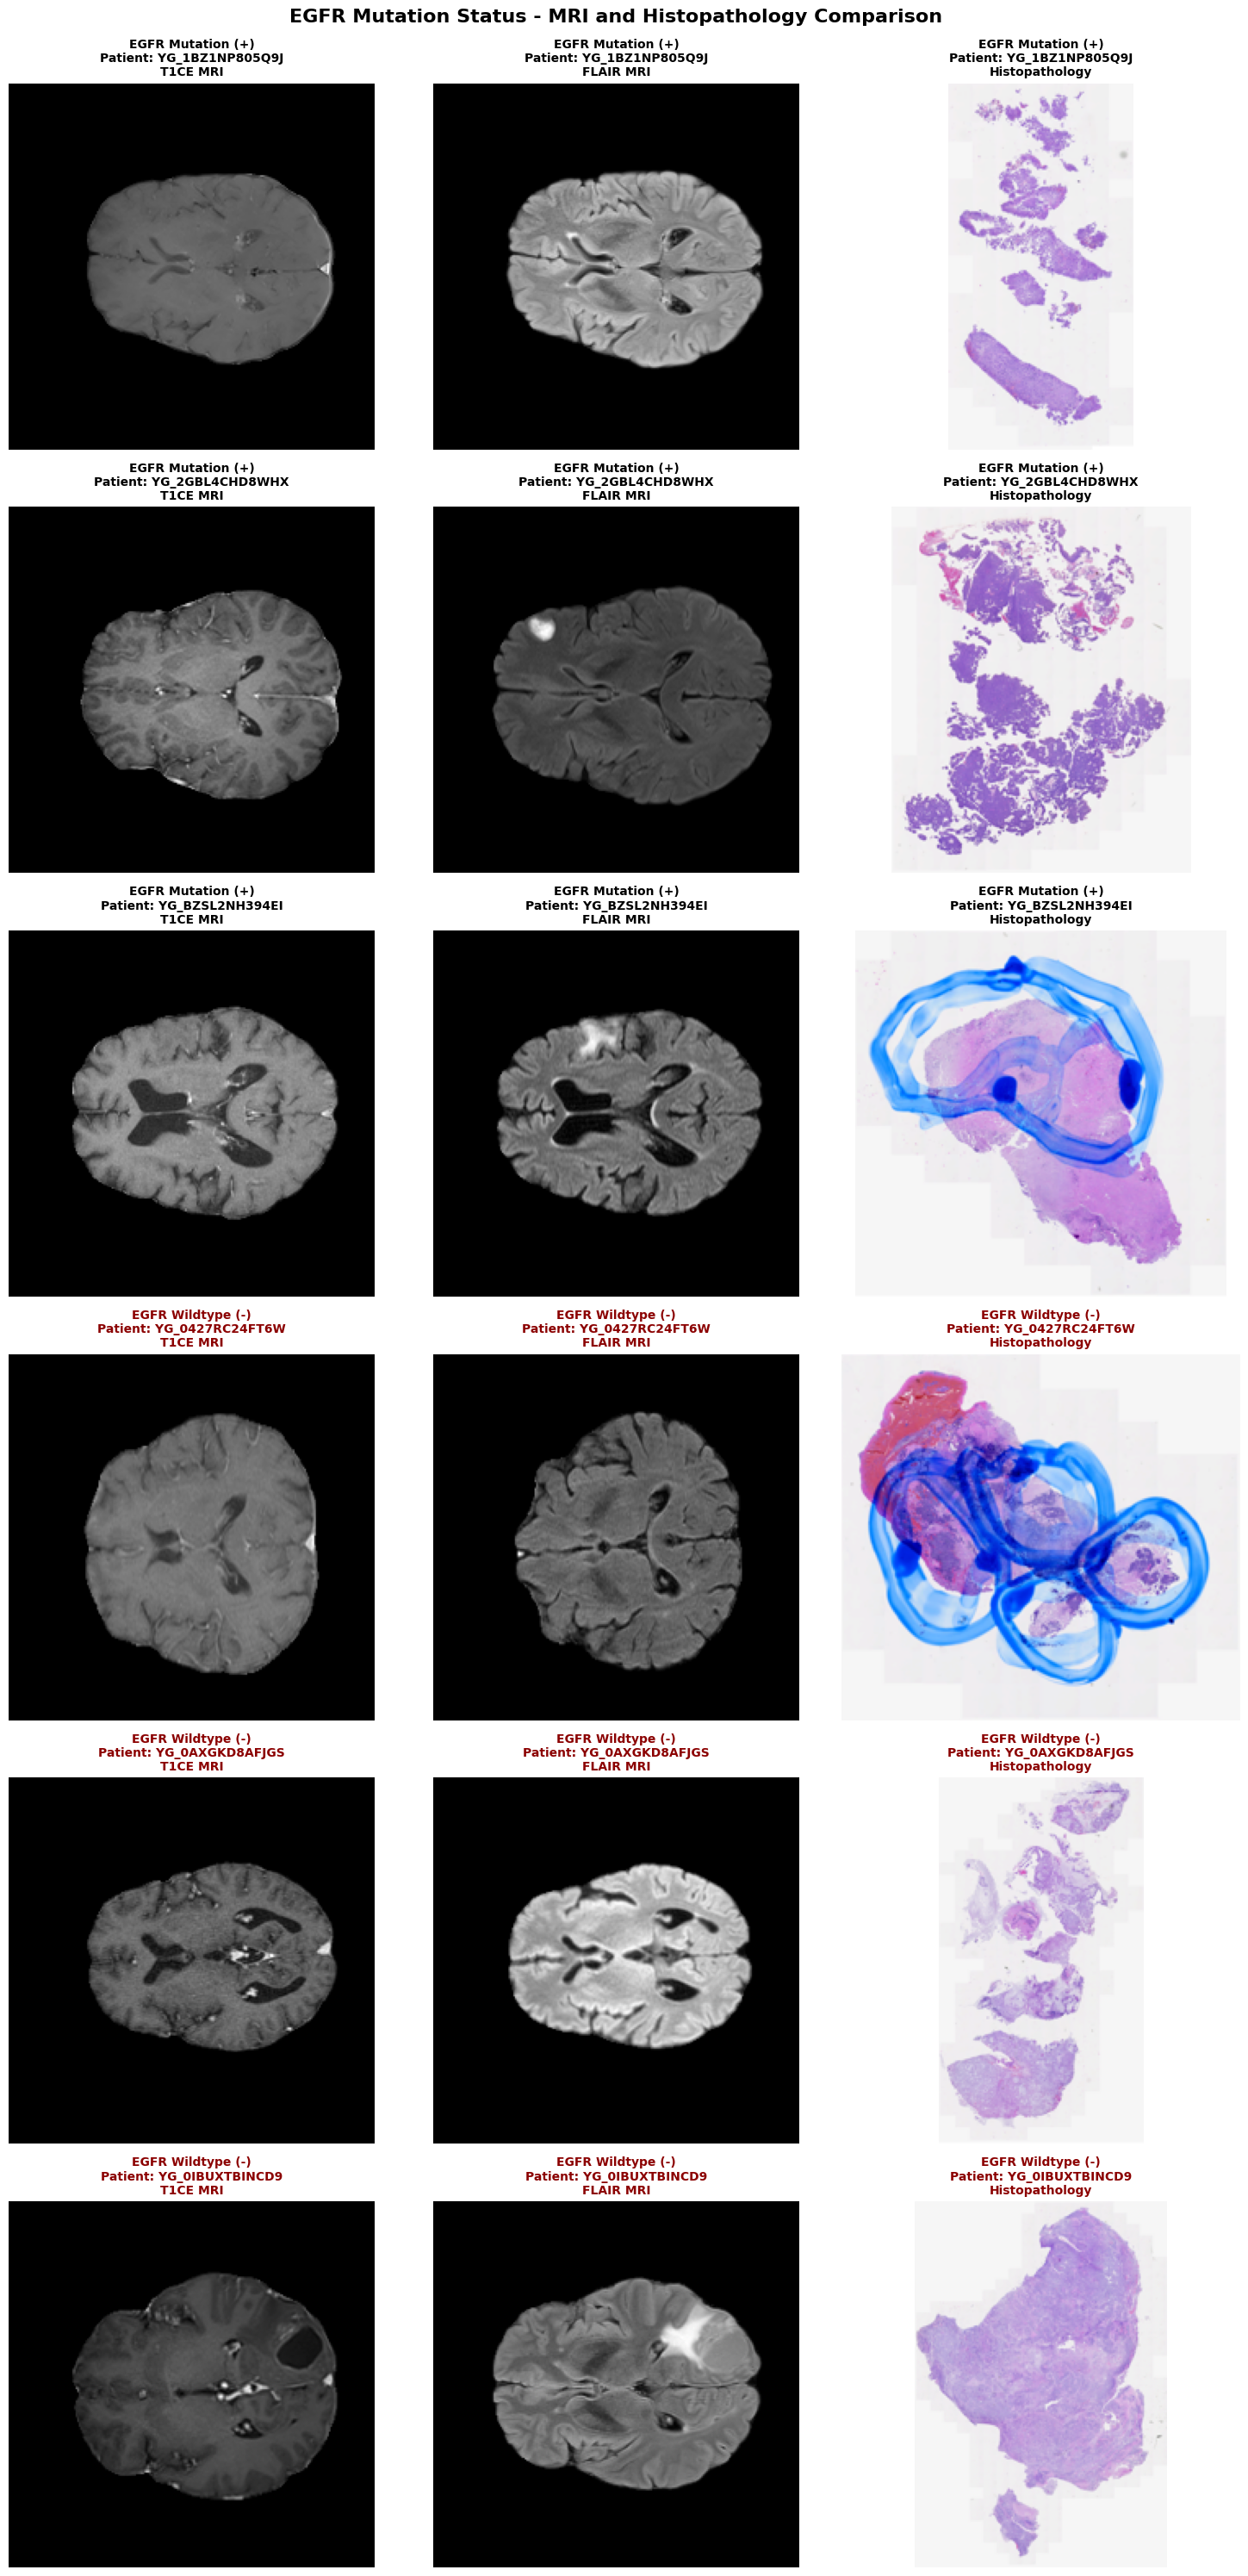


DISPLAYED PATIENTS - EGFR MUTATION (+)
1. Patient ID: YG_1BZ1NP805Q9J
   Accession ID: YG_3ULZIC6OE5NB
   T1CE: YG_3ULZIC6OE5NB_t1ce_img.nii.gz
   FLAIR: YG_3ULZIC6OE5NB_flair_img.nii.gz
   Histology: YG_3ULZIC6OE5NB_wsi.svs

2. Patient ID: YG_2GBL4CHD8WHX
   Accession ID: YG_MGO4964VSKLW
   T1CE: YG_MGO4964VSKLW_t1ce_img.nii.gz
   FLAIR: YG_MGO4964VSKLW_flair_img.nii.gz
   Histology: YG_MGO4964VSKLW_wsi.svs

3. Patient ID: YG_BZSL2NH394EI
   Accession ID: YG_3OAF908JG3XG
   T1CE: YG_3OAF908JG3XG_t1ce_img.nii.gz
   FLAIR: YG_3OAF908JG3XG_flair_img.nii.gz
   Histology: YG_3OAF908JG3XG_wsi.svs

DISPLAYED PATIENTS - EGFR WILDTYPE (-)
1. Patient ID: YG_0427RC24FT6W
   Accession ID: YG_XKGYFGZHUMTO
   T1CE: YG_XKGYFGZHUMTO_t1ce_img.nii.gz
   FLAIR: YG_XKGYFGZHUMTO_flair_img.nii.gz
   Histology: YG_XKGYFGZHUMTO_wsi.svs

2. Patient ID: YG_0AXGKD8AFJGS
   Accession ID: YG_HAEAKFOSOSWC
   T1CE: YG_HAEAKFOSOSWC_t1ce_img.nii.gz
   FLAIR: YG_HAEAKFOSOSWC_flair_img.nii.gz
   Histology: YG_HAEAKFOS

In [5]:
"""
Visualize MRI and Histology Images for EGFR Mutation Status
This script displays sample images from patients with and without EGFR mutations
"""

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from pathlib import Path

try:
    import nibabel as nib
except:
    print("Warning: nibabel not installed. Install with: pip install nibabel")

# Configuration - UPDATE THESE PATHS TO MATCH YOUR SETUP
clinical_path = r"D:\paper\external.xlsx"
histology_base = r"C:\Users\Shahinur\Downloads\PKG_Dataset\PKG - Brain-Mets-Lung-MRI-Path-Segs_histopathology images\data"
mri_base = r"C:\Users\Shahinur\Downloads\PKG_Dataset\PKG - Brain-Mets-Lung-MRI-Path-Segs_radiology_images\Brain-Mets-Lung-MRI-Path-Segs"
img_size = 224

print("="*80)
print("EGFR MUTATION STATUS - IMAGE VISUALIZATION")
print("="*80)

# Load clinical data
print("\nLoading clinical data...")
clinical_df = pd.read_excel(clinical_path) if clinical_path.endswith('.xlsx') else pd.read_csv(clinical_path)
print(f"Clinical data shape: {clinical_df.shape}")

# Find EGFR status column
target_col = None
for col in clinical_df.columns:
    if 'EGFR' in col.upper() and 'STATUS' in col.upper():
        target_col = col
        break

if target_col is None:
    raise ValueError("EGFR Status column not found!")

print(f"Using target column: '{target_col}'")
print(f"\nTarget distribution:")
print(clinical_df[target_col].value_counts())

# Get patient IDs
if 'patientID' in clinical_df.columns:
    patient_ids = clinical_df['patientID'].astype(str).tolist()
else:
    patient_ids = clinical_df.iloc[:, 0].astype(str).tolist()

accession_ids = clinical_df.iloc[:, 0].astype(str).tolist()  # For histology files
labels = clinical_df[target_col].values

# Helper functions
def load_nifti(path, img_size=224):
    """Load and process NIfTI MRI files"""
    try:
        path = Path(path)
        
        # Handle compressed files
        if path.suffix == '' and not str(path).endswith('.nii'):
            import zipfile
            if zipfile.is_zipfile(path):
                with zipfile.ZipFile(path) as zf:
                    nii_files = [f for f in zf.namelist() if f.endswith('.nii') or f.endswith('.nii.gz')]
                    if nii_files:
                        with zf.open(nii_files[0]) as f:
                            img_data = nib.load(f).get_fdata()
                    else:
                        img_data = nib.load(str(path)).get_fdata()
            else:
                img_data = nib.load(str(path)).get_fdata()
        else:
            img_data = nib.load(str(path)).get_fdata()
        
        # Get middle slice
        if len(img_data.shape) == 3:
            img_slice = img_data[:, :, img_data.shape[2] // 2]
        else:
            img_slice = img_data[:, :, 0, 0] if len(img_data.shape) == 4 else img_data
        
        # Normalize to 0-255
        img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min() + 1e-8) * 255
        return cv2.resize(img_slice.astype(np.uint8), (img_size, img_size))
    except Exception as e:
        print(f"Error loading NIfTI {path}: {e}")
        # Fallback
        try:
            img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
            if img is None:
                img = np.array(Image.open(path).convert('L'))
            return cv2.resize(img, (img_size, img_size))
        except:
            return np.zeros((img_size, img_size), dtype=np.uint8)

def load_svs(path, img_size=224):
    """Load and process SVS histology files"""
    try:
        from openslide import OpenSlide
        slide = OpenSlide(str(path))
        level = slide.level_count - 1
        thumb = slide.read_region((0, 0), level, slide.level_dimensions[level])
        thumb.thumbnail((img_size, img_size))
        return np.array(thumb.convert('RGB'))
    except:
        # Fallback to PIL
        try:
            img = Image.open(path)
            img.thumbnail((img_size, img_size))
            return np.array(img.convert('RGB'))
        except Exception as e:
            print(f"Error loading SVS {path}: {e}")
            return np.zeros((img_size, img_size, 3), dtype=np.uint8)

def find_patient_mri(patient_id, mri_base_path):
    """Find MRI files for a patient"""
    mri_base_path = Path(mri_base_path)
    all_dirs = {d.name: d for d in mri_base_path.iterdir() if d.is_dir()}
    
    # Try different matching strategies
    patient_dir = None
    if patient_id in all_dirs:
        patient_dir = all_dirs[patient_id]
    elif patient_id.startswith('YG_') and patient_id[3:] in all_dirs:
        patient_dir = all_dirs[patient_id[3:]]
    elif f"YG_{patient_id}" in all_dirs:
        patient_dir = all_dirs[f"YG_{patient_id}"]
    
    if patient_dir and patient_dir.exists():
        t1ce_files = list(patient_dir.glob("*t1ce*"))
        flair_files = list(patient_dir.glob("*flair*"))
        
        if len(t1ce_files) > 0 and len(flair_files) > 0:
            return t1ce_files[0], flair_files[0]
    
    return None, None

def find_patient_histology(accession_id, hist_base_path):
    """Find histology files for a patient"""
    hist_base_path = Path(hist_base_path)
    
    svs_files = list(hist_base_path.glob(f"*{accession_id}*.svs"))
    if len(svs_files) == 0 and accession_id.startswith('YG_'):
        svs_files = list(hist_base_path.glob(f"*{accession_id[3:]}*.svs"))
    
    if len(svs_files) > 0:
        return svs_files[0]
    return None

# Find patients with and without EGFR mutation
print("\nFinding patients with available images...")
egfr_positive = []  # EGFR mutation present (label = 1)
egfr_negative = []  # EGFR wildtype (label = 0)

for idx, (patient_id, accession_id, label) in enumerate(zip(patient_ids, accession_ids, labels)):
    # Check MRI
    t1ce_path, flair_path = find_patient_mri(patient_id, mri_base)
    
    # Check Histology
    svs_path = find_patient_histology(accession_id, histology_base)
    
    # Only include patients with both MRI and histology
    if t1ce_path and flair_path and svs_path:
        patient_data = {
            'patient_id': patient_id,
            'accession_id': accession_id,
            't1ce_path': t1ce_path,
            'flair_path': flair_path,
            'svs_path': svs_path,
            'label': label
        }
        
        if label == 1:
            egfr_positive.append(patient_data)
        else:
            egfr_negative.append(patient_data)

print(f"\nFound {len(egfr_positive)} EGFR Mutation patients with complete data")
print(f"Found {len(egfr_negative)} EGFR Wildtype patients with complete data")

# Select samples to display (up to 3 from each group)
n_samples = min(3, len(egfr_positive), len(egfr_negative))

if n_samples == 0:
    print("\nERROR: No patients found with both MRI and histology data!")
    print("Please check your data paths and file availability.")
else:
    print(f"\nDisplaying {n_samples} samples from each group...")
    
    # Create visualization
    fig, axes = plt.subplots(2 * n_samples, 3, figsize=(15, 5 * n_samples * 2))
    
    # Display EGFR Mutation patients
    for i in range(n_samples):
        patient = egfr_positive[i]
        
        # Load T1CE
        t1ce_img = load_nifti(patient['t1ce_path'], img_size)
        axes[i, 0].imshow(t1ce_img, cmap='gray')
        axes[i, 0].set_title(f"EGFR Mutation (+)\nPatient: {patient['patient_id']}\nT1CE MRI", 
                             fontsize=10, fontweight='bold')
        axes[i, 0].axis('off')
        
        # Load FLAIR
        flair_img = load_nifti(patient['flair_path'], img_size)
        axes[i, 1].imshow(flair_img, cmap='gray')
        axes[i, 1].set_title(f"EGFR Mutation (+)\nPatient: {patient['patient_id']}\nFLAIR MRI", 
                             fontsize=10, fontweight='bold')
        axes[i, 1].axis('off')
        
        # Load Histology
        hist_img = load_svs(patient['svs_path'], img_size)
        axes[i, 2].imshow(hist_img)
        axes[i, 2].set_title(f"EGFR Mutation (+)\nPatient: {patient['patient_id']}\nHistopathology", 
                             fontsize=10, fontweight='bold')
        axes[i, 2].axis('off')
    
    # Display EGFR Wildtype patients
    for i in range(n_samples):
        patient = egfr_negative[i]
        row_idx = i + n_samples
        
        # Load T1CE
        t1ce_img = load_nifti(patient['t1ce_path'], img_size)
        axes[row_idx, 0].imshow(t1ce_img, cmap='gray')
        axes[row_idx, 0].set_title(f"EGFR Wildtype (-)\nPatient: {patient['patient_id']}\nT1CE MRI", 
                                   fontsize=10, fontweight='bold', color='darkred')
        axes[row_idx, 0].axis('off')
        
        # Load FLAIR
        flair_img = load_nifti(patient['flair_path'], img_size)
        axes[row_idx, 1].imshow(flair_img, cmap='gray')
        axes[row_idx, 1].set_title(f"EGFR Wildtype (-)\nPatient: {patient['patient_id']}\nFLAIR MRI", 
                                   fontsize=10, fontweight='bold', color='darkred')
        axes[row_idx, 1].axis('off')
        
        # Load Histology
        hist_img = load_svs(patient['svs_path'], img_size)
        axes[row_idx, 2].imshow(hist_img)
        axes[row_idx, 2].set_title(f"EGFR Wildtype (-)\nPatient: {patient['patient_id']}\nHistopathology", 
                                   fontsize=10, fontweight='bold', color='darkred')
        axes[row_idx, 2].axis('off')
    
    plt.suptitle('EGFR Mutation Status - MRI and Histopathology Comparison', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # Save the figure
    output_path = "./egfr_patient_images_comparison.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\nVisualization saved to: {output_path}")
    
    plt.show()
    
    # Print patient details
    print("\n" + "="*80)
    print("DISPLAYED PATIENTS - EGFR MUTATION (+)")
    print("="*80)
    for i, patient in enumerate(egfr_positive[:n_samples], 1):
        print(f"{i}. Patient ID: {patient['patient_id']}")
        print(f"   Accession ID: {patient['accession_id']}")
        print(f"   T1CE: {patient['t1ce_path'].name}")
        print(f"   FLAIR: {patient['flair_path'].name}")
        print(f"   Histology: {patient['svs_path'].name}")
        print()
    
    print("="*80)
    print("DISPLAYED PATIENTS - EGFR WILDTYPE (-)")
    print("="*80)
    for i, patient in enumerate(egfr_negative[:n_samples], 1):
        print(f"{i}. Patient ID: {patient['patient_id']}")
        print(f"   Accession ID: {patient['accession_id']}")
        print(f"   T1CE: {patient['t1ce_path'].name}")
        print(f"   FLAIR: {patient['flair_path'].name}")
        print(f"   Histology: {patient['svs_path'].name}")
        print()

print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)